In [17]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdmolops, AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys


from scipy.stats import pearsonr


# sklearn ML models
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import svm

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import  LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold

import joblib
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'


In [2]:
df = pd.read_csv('../01-database-preprocessing-1203dp-to-1115dp/raw/atom_number_wH_sort_1115-backbone-correction-newSMILES.csv')
df.head()

Nickname  bandgap(eV)                                         c_smiles  \
0     P3HT         1.93                                CCCCCCc1cc(C)sc1C   
1    P3HST         1.82                               CCCCCCSc1cc(C)sc1C   
2     POPT         1.76                   CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1   
3    PT-C1         1.92            CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1   
4    PT-C2         1.89  CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1   

                                           newSMILES Ref.No  
0  Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...    S10  
1  CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...   S123  
2  Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...   S126  
3  COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...   S122  
4  COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...   S122

# exp HOMO-LUMO gap

In [3]:
df_exp = df['bandgap(eV)']
df_exp

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1110    1.68
1111    1.65
1112    1.66
1113    1.52
1114    1.73
Name: bandgap(eV), Length: 1115, dtype: float64

# MACCS-167 descriptors generation

In [4]:
smiles_list = df['c_smiles'].values
len(smiles_list)

1115

In [5]:
# proof and make a list of SMILES
c_smiles = []
for ds in smiles_list:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        print('Invalid SMILES:', ds)
len(c_smiles)

1115

In [6]:
def maccs_fpts(data):
    maccs_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = MACCSkeys.GenMACCSKeys(mol)
        mfpts = np.array(fpts)
        maccs_fpts.append(mfpts)
    return np.array(maccs_fpts)

maccs_fpts = maccs_fpts(c_smiles)

maccs_fpts.shape


#Name the feature rows as f_0, f_1, f_2...
feature_col=[]
for i in range(maccs_fpts.shape[1]):
    feature_col.append("m_"+str(i))
    i+=1
MACCS_fingerprints = pd.DataFrame(data = maccs_fpts, columns=feature_col)
MACCS_fingerprints



m_0  m_1  m_2  m_3  m_4  m_5  m_6  m_7  m_8  m_9  ...  m_157  m_158  \
0       0    0    0    0    0    0    0    0    0    0  ...      0      0   
1       0    0    0    0    0    0    0    0    0    0  ...      0      0   
2       0    0    0    0    0    0    0    0    0    0  ...      0      0   
3       0    0    0    0    0    0    0    0    0    0  ...      1      0   
4       0    0    0    0    0    0    0    0    0    0  ...      1      0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
1110    0    0    0    0    0    0    0    0    0    0  ...      0      0   
1111    0    0    0    0    0    0    0    0    0    0  ...      1      1   
1112    0    0    0    0    0    0    0    0    0    0  ...      1      1   
1113    0    0    0    0    0    0    0    0    0    0  ...      0      1   
1114    0    0    0    0    0    0    0    0    0    0  ...      0      1   

      m_159  m_160  m_161  m_162  m_163  m_164  m_165  m_166  
0         0      1      0      1      0      0      1      0  
1         0      1      0      1      0      0      1      0  
2         0      1      0      1      1      0      1      0  
3         1      1      0      1      0      1      1      0  
4         1      1      0      1      0      1      1      0  
...     ...    ...    ...    ...    ...    ...    ...    ...  
1110      0      1      1      1      1      0      1      0  
1111      1      1      1      1      1      1      1      0  
1112      1      1      1      1      1      1      1      0  
1113      1      1      1      1      1      1      1      0  
1114      1      1      1      1      1      1      1      0  

[1115 rows x 167 columns]

In [7]:
# MACCS_fingerprints.to_csv('monomer-1115dp-maccs-167.csv', index=False)

## drop all 0 columns

In [8]:
# # 使用列的bool索引来删除全部是0的列
# MACCS_fingerprints = MACCS_fingerprints.loc[:, (MACCS_fingerprints != 0).any(axis=0)]
# MACCS_fingerprints

m_3  m_13  m_17  m_18  m_19  m_20  m_24  m_26  m_28  m_29  ...  m_156  \
0       0     0     0     0     0     0     0     0     0     0  ...      0   
1       0     0     0     0     0     0     0     0     0     0  ...      0   
2       0     0     0     0     0     0     0     0     0     0  ...      0   
3       0     0     0     0     0     0     0     0     0     0  ...      0   
4       0     0     0     0     0     0     0     0     0     0  ...      0   
...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
1110    0     0     0     0     0     0     0     0     0     0  ...      1   
1111    0     0     0     0     0     0     0     0     0     0  ...      1   
1112    0     0     0     0     0     0     0     0     0     0  ...      1   
1113    0     0     0     0     0     0     0     1     0     0  ...      1   
1114    0     0     0     0     0     0     0     0     0     0  ...      1   

      m_157  m_158  m_159  m_160  m_161  m_162  m_163  m_164  m_165  
0         0      0      0      1      0      1      0      0      1  
1         0      0      0      1      0      1      0      0      1  
2         0      0      0      1      0      1      1      0      1  
3         1      0      1      1      0      1      0      1      1  
4         1      0      1      1      0      1      0      1      1  
...     ...    ...    ...    ...    ...    ...    ...    ...    ...  
1110      0      0      0      1      1      1      1      0      1  
1111      1      1      1      1      1      1      1      1      1  
1112      1      1      1      1      1      1      1      1      1  
1113      0      1      1      1      1      1      1      1      1  
1114      0      1      1      1      1      1      1      1      1  

[1115 rows x 126 columns]

# drop sp3-N polymers + donor-692

In [8]:
# non_alkyl_idx = [46,49,68,79,202,210,217,252,255,262,273,274,318,355,358,375,441,
#                 455,810,812,914,932,934,937,947,1007]

sp3_N_list = [  24,   44,  191,  201,  206,  209,  251,  317,  318,  332,  374,
             381,  388,  454,  913,  931,  936, 1006]
drop_list = sp3_N_list+[691]
print('Total data points: ', 1115-len(drop_list))

Total data points:  1096


In [9]:
MACCS_fingerprints = MACCS_fingerprints[~MACCS_fingerprints.index.isin(drop_list)].reset_index(drop=True)
df_exp = df_exp[~df_exp.index.isin(drop_list)].reset_index(drop=True)

# ML regression

## b. train and test

In [10]:
def acc(y_test,y_pred):
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = MSE ** 0.5
    R2 = r2_score(y_test,y_pred)
#     p = pearsonr(y_test,y_pred.reshape(-1,1)) # y_pred shape = (xxx,)
    p = pearsonr(y_test,y_pred) # y_pred shape = (xxx,)
    r = p[0]**2
    MAE = mean_absolute_error(y_test,y_pred)
    return RMSE, R2, r, MAE

In [11]:
X = MACCS_fingerprints
X

m_0  m_1  m_2  m_3  m_4  m_5  m_6  m_7  m_8  m_9  ...  m_157  m_158  \
0       0    0    0    0    0    0    0    0    0    0  ...      0      0   
1       0    0    0    0    0    0    0    0    0    0  ...      0      0   
2       0    0    0    0    0    0    0    0    0    0  ...      0      0   
3       0    0    0    0    0    0    0    0    0    0  ...      1      0   
4       0    0    0    0    0    0    0    0    0    0  ...      1      0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
1091    0    0    0    0    0    0    0    0    0    0  ...      0      0   
1092    0    0    0    0    0    0    0    0    0    0  ...      1      1   
1093    0    0    0    0    0    0    0    0    0    0  ...      1      1   
1094    0    0    0    0    0    0    0    0    0    0  ...      0      1   
1095    0    0    0    0    0    0    0    0    0    0  ...      0      1   

      m_159  m_160  m_161  m_162  m_163  m_164  m_165  m_166  
0         0      1      0      1      0      0      1      0  
1         0      1      0      1      0      0      1      0  
2         0      1      0      1      1      0      1      0  
3         1      1      0      1      0      1      1      0  
4         1      1      0      1      0      1      1      0  
...     ...    ...    ...    ...    ...    ...    ...    ...  
1091      0      1      1      1      1      0      1      0  
1092      1      1      1      1      1      1      1      0  
1093      1      1      1      1      1      1      1      0  
1094      1      1      1      1      1      1      1      0  
1095      1      1      1      1      1      1      1      0  

[1096 rows x 167 columns]

In [12]:
y = df_exp
y

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1091    1.68
1092    1.65
1093    1.66
1094    1.52
1095    1.73
Name: bandgap(eV), Length: 1096, dtype: float64

## c. model define

In [13]:
model = HistGradientBoostingRegressor()
# model = LGBMRegressor(force_col_wise=True, verbose=-1)
# model = GradientBoostingRegressor()
# model = XGBRegressor()
# model = AdaBoostRegressor()
# model = RandomForestRegressor()

## d. 10fold-CV plus 10fold-CV average

In [14]:
foldername = 'xgb-10fold-cv-plus-10fold-cv-average'
# foldername = 'hgbr-10fold-cv-plus-10fold-cv-average'
# os.mkdir(foldername)

In [15]:
xfold=10
kf = KFold(n_splits=xfold, shuffle=True, random_state=42)

In [18]:
scores = []

# save index for train and test of each fold
train_idx_list = []
test_idx_list = []
i=0
for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_idx_list.append(train_index)
    test_idx_list.append(test_index)
    
    kf_sub = KFold(n_splits=xfold, shuffle=True, random_state=42)
    for fold_idx_sub, (train_index_sub, test_index_sub) in enumerate(kf_sub.split(X_train)):
        X_kf_train, X_kf_test = X_train.iloc[train_index_sub], X_train.iloc[test_index_sub]
        y_kf_train, y_kf_test = y_train.iloc[train_index_sub], y_train.iloc[test_index_sub]
        

        
        # 训练模型
        model.fit(X_kf_train, y_kf_train)

        # 获取模型预测结果
        y_pred = model.predict(X_kf_test)
        
        # 在验证集上做预测

        RMSE_test, R2_test, r_test, MAE_test = acc(y_kf_test,y_pred)

        scores.append([RMSE_test, R2_test, r_test, MAE_test])
        
        # 保存模型
        model_filename = foldername + f'/model_fold_{fold_idx + 1}_subfold_{fold_idx_sub + 1}.pkl'
        joblib.dump(model, model_filename)
        
        i+=1
        
        print('model:',i)


model: 1
model: 2
model: 3
model: 4
model: 5
model: 6
model: 7
model: 8
model: 9
model: 10
model: 11
model: 12
model: 13
model: 14
model: 15
model: 16
model: 17
model: 18
model: 19
model: 20
model: 21
model: 22
model: 23
model: 24
model: 25
model: 26
model: 27
model: 28
model: 29
model: 30
model: 31
model: 32
model: 33
model: 34
model: 35
model: 36
model: 37
model: 38
model: 39
model: 40
model: 41
model: 42
model: 43
model: 44
model: 45
model: 46
model: 47
model: 48
model: 49
model: 50
model: 51
model: 52
model: 53
model: 54
model: 55
model: 56
model: 57
model: 58
model: 59
model: 60
model: 61
model: 62
model: 63
model: 64
model: 65
model: 66
model: 67
model: 68
model: 69
model: 70
model: 71
model: 72
model: 73
model: 74
model: 75
model: 76
model: 77
model: 78
model: 79
model: 80
model: 81
model: 82
model: 83
model: 84
model: 85
model: 86
model: 87
model: 88
model: 89
model: 90
model: 91
model: 92
model: 93
model: 94
model: 95
model: 96
model: 97
model: 98
model: 99
model: 100


In [19]:
scores_df = pd.DataFrame(scores, columns = ['RMSE', 'R2', 'r', 'MAE'])
index_list=[f'fold{i}' for i in range(1,xfold+1)]
index = [index_list[i%xfold] for i in range(xfold**2)]

scores_df.index = index
scores_df.round(3)

RMSE     R2      r    MAE
fold1   0.145  0.377  0.428  0.106
fold2   0.132  0.476  0.489  0.095
fold3   0.137  0.594  0.599  0.101
fold4   0.166  0.529  0.554  0.113
fold5   0.128  0.547  0.559  0.091
...       ...    ...    ...    ...
fold6   0.149  0.565  0.586  0.107
fold7   0.127  0.621  0.631  0.096
fold8   0.154  0.384  0.387  0.109
fold9   0.147  0.369  0.380  0.102
fold10  0.130  0.525  0.571  0.086

[100 rows x 4 columns]

## e. load 10-fold cv plus 10-fold cv average

In [20]:
models = []
for fold_idx in range(xfold):
    for fold_idx_sub in range(xfold):
        model_filename = foldername + f'/model_fold_{fold_idx + 1}_subfold_{fold_idx_sub + 1}.pkl'
        model = joblib.load(model_filename)
        models.append(model)
len(models)

100

In [21]:
scores = []

for i in range(xfold):
    train_index = train_idx_list[i]
    test_index = test_idx_list[i]
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    
    predictions = []
    
    for j in range(xfold):
        model = models[i*xfold+j]     
               
        y_pred = model.predict(X_test)
        predictions.append(y_pred)
        
        print('model idx: ',i*xfold+j)
        
    df_predictions = pd.DataFrame(predictions)
    df_predictions = df_predictions.T
    df_predictions['mean'] = df_predictions.iloc[:,:4].mean(axis = 1)
    
    RMSE_test, R2_test, r_test, MAE_test = acc(y_test,df_predictions['mean'])
    scores.append([RMSE_test, R2_test, r_test, MAE_test])


model idx:  0
model idx:  1
model idx:  2
model idx:  3
model idx:  4
model idx:  5
model idx:  6
model idx:  7
model idx:  8
model idx:  9
model idx:  10
model idx:  11
model idx:  12
model idx:  13
model idx:  14
model idx:  15
model idx:  16
model idx:  17
model idx:  18
model idx:  19
model idx:  20
model idx:  21
model idx:  22
model idx:  23
model idx:  24
model idx:  25
model idx:  26
model idx:  27
model idx:  28
model idx:  29
model idx:  30
model idx:  31
model idx:  32
model idx:  33
model idx:  34
model idx:  35
model idx:  36
model idx:  37
model idx:  38
model idx:  39
model idx:  40
model idx:  41
model idx:  42
model idx:  43
model idx:  44
model idx:  45
model idx:  46
model idx:  47
model idx:  48
model idx:  49
model idx:  50
model idx:  51
model idx:  52
model idx:  53
model idx:  54
model idx:  55
model idx:  56
model idx:  57
model idx:  58
model idx:  59
model idx:  60
model idx:  61
model idx:  62
model idx:  63
model idx:  64
model idx:  65
model idx:  66
model

In [22]:
scores_df = pd.DataFrame(scores, columns = ['RMSE', 'R2', 'r', 'MAE'])
scores_df.loc['mean'] = scores_df.iloc[:xfold,:].mean()
scores_df.loc['std'] = scores_df.iloc[:xfold,:].std()
scores_df.round(3)

RMSE     R2      r    MAE
0     0.133  0.499  0.513  0.095
1     0.141  0.518  0.526  0.104
2     0.167  0.448  0.448  0.123
3     0.155  0.501  0.504  0.101
4     0.133  0.563  0.565  0.097
5     0.148  0.430  0.431  0.106
6     0.155  0.500  0.517  0.111
7     0.148  0.351  0.381  0.095
8     0.148  0.566  0.567  0.105
9     0.134  0.460  0.463  0.097
mean  0.146  0.484  0.492  0.103
std   0.011  0.064  0.060  0.009

## f. plot

In [23]:
def parity_plot(y,y_train, y_test,y_train_pred, y_test_pred, r2_train, r2_test, fold_idx):
    xmax=y.max()
    xmin=y.min()
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    plt.plot((xmin,xmax), (xmin,xmax), ls='--', c='black', linewidth=3)

    plt.scatter(y_train, y_train_pred, color ='blue', s=75, label=f"$R^2 (train)$={round(r2_train, 3)}")
    plt.scatter(y_test, y_test_pred, color ='red', s=75, label=f"$R^2 (test)$={round(r2_test, 3)}")
    plt.legend(fontsize = 20)

    ax.tick_params(direction='in', width=2)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    for spine in ax.spines.values():
        spine.set_linewidth(2)


    plt.xlabel('$E_{opt}^{exp}$ (eV)', fontsize=38, font="arial", labelpad=10)
    plt.ylabel('$E_{opt}^{ML}$ (eV)', fontsize=38, font="arial", labelpad=10)
    plt.title('model index in '+str(xfold)+'-fold CV: '+str(fold_idx), fontsize=25)

    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
    plt.gca().tick_params(axis='both', length=10, width=2)
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.show()

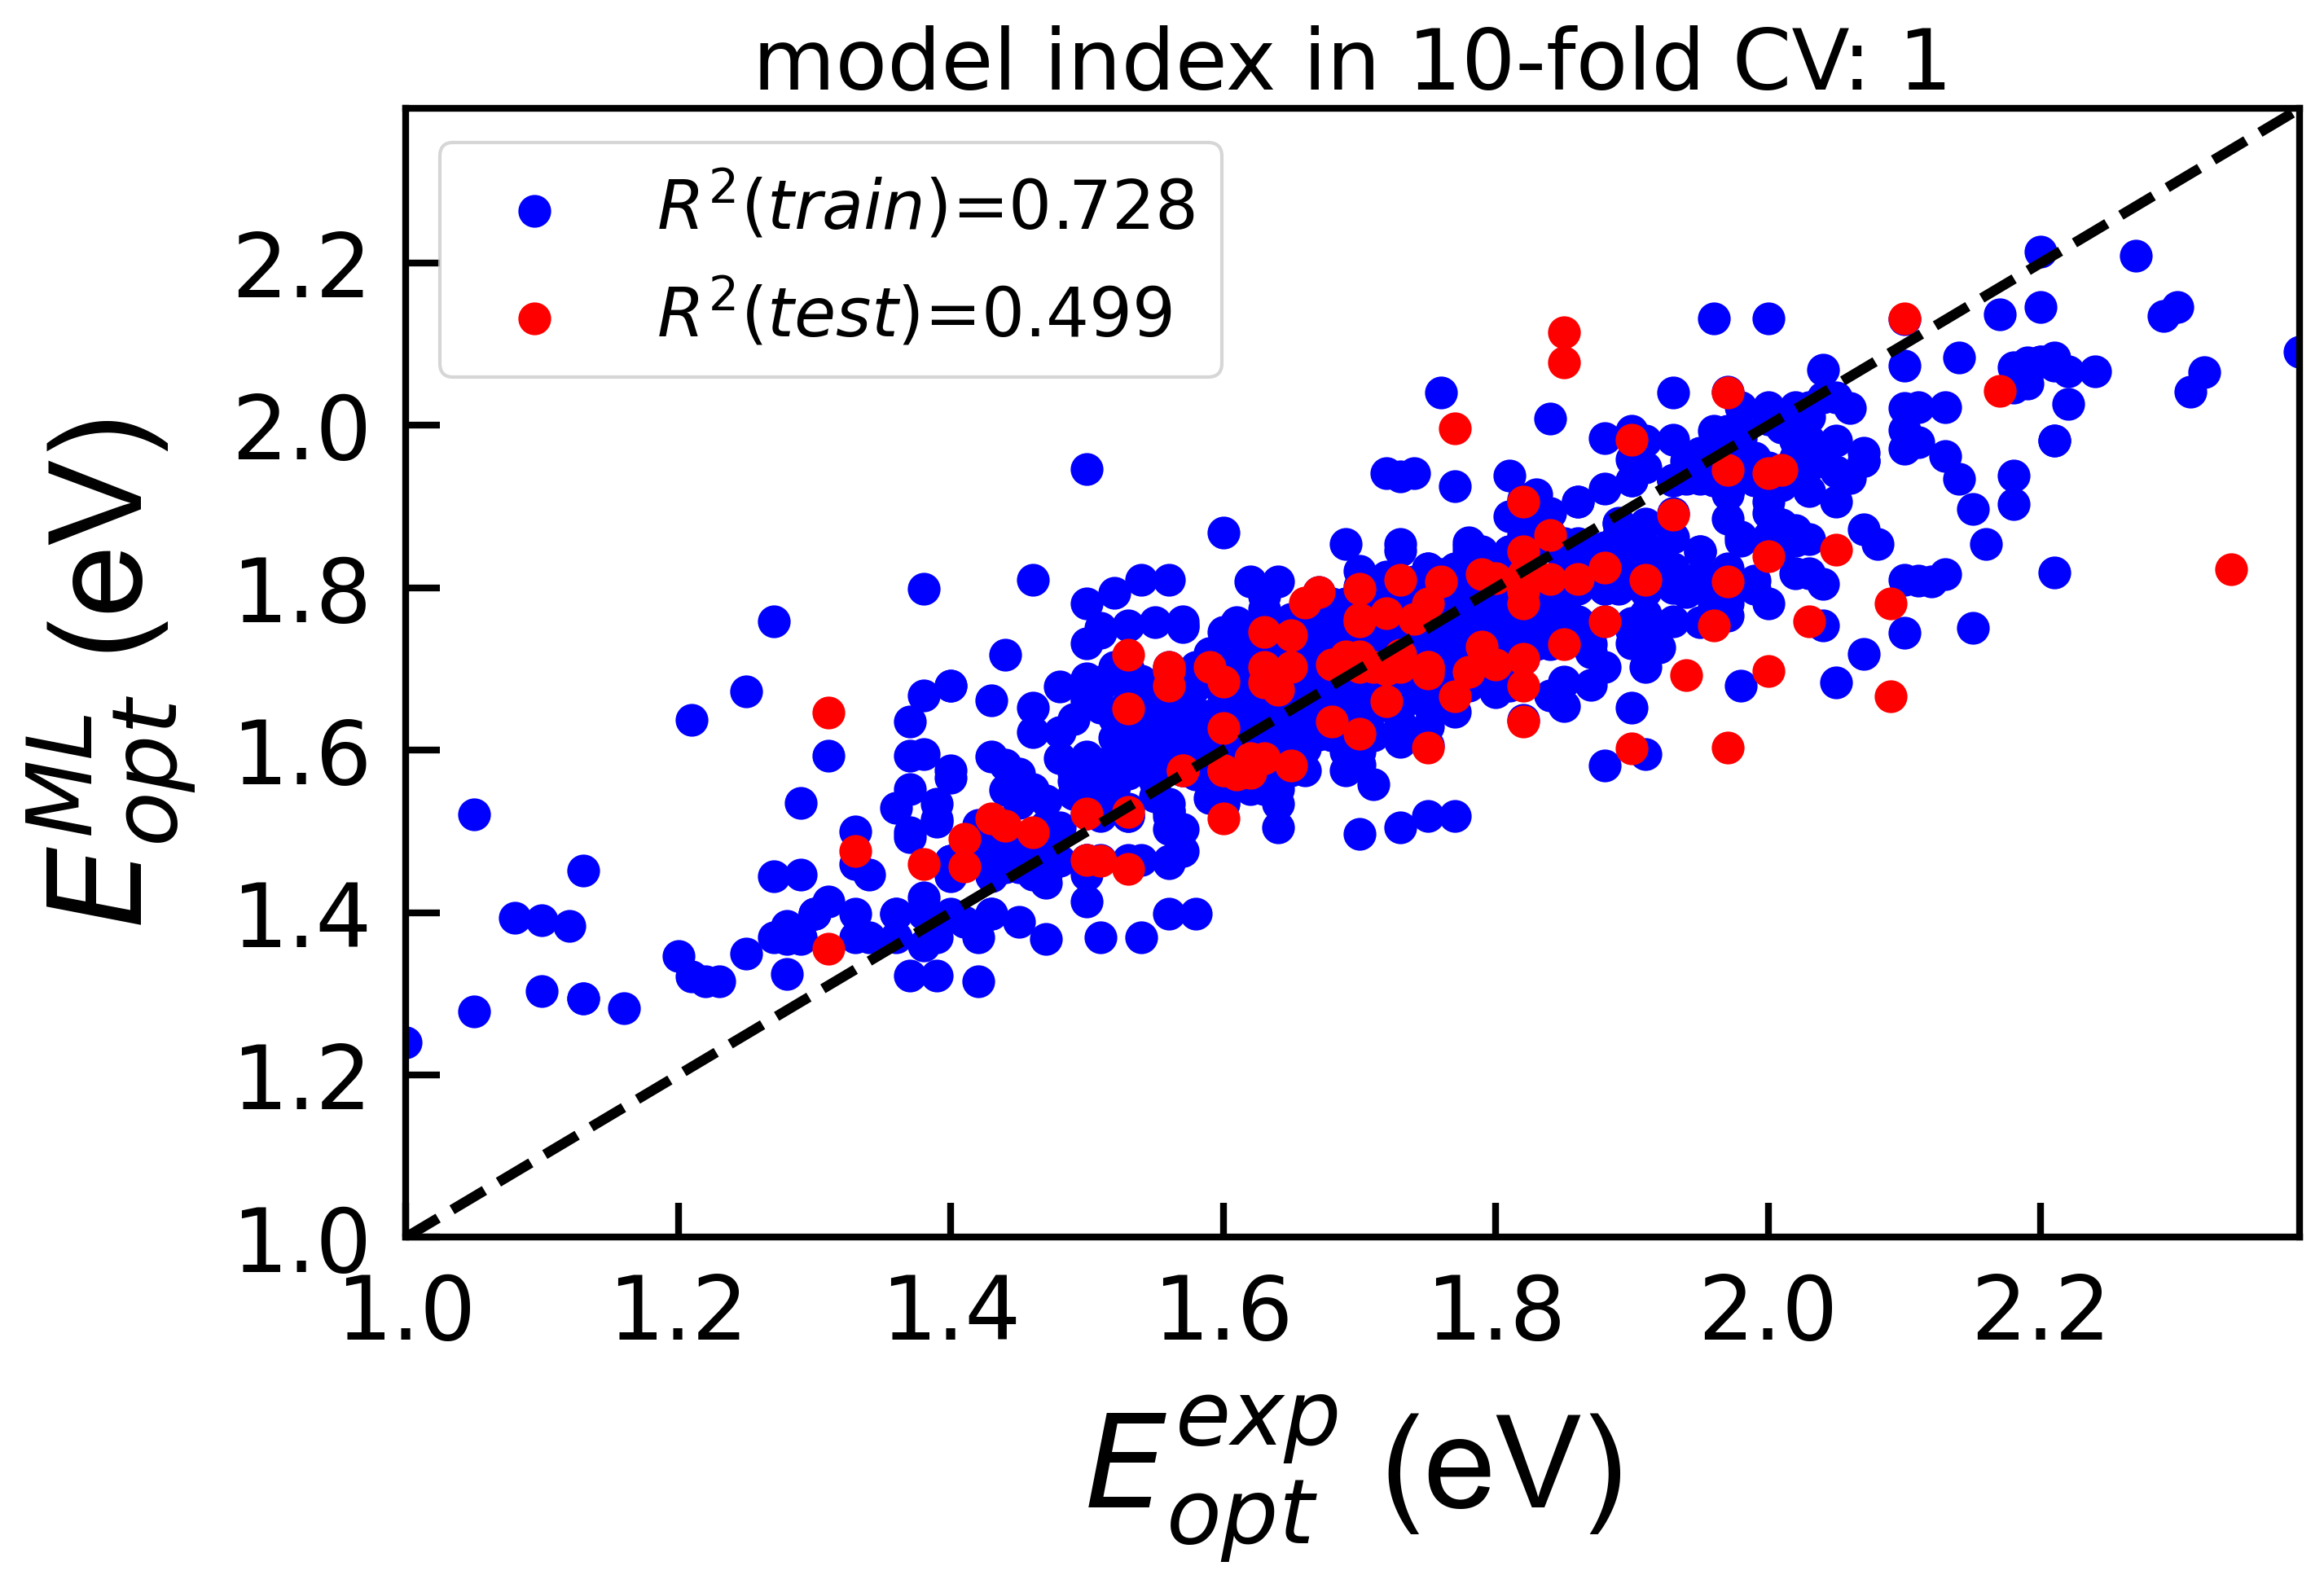

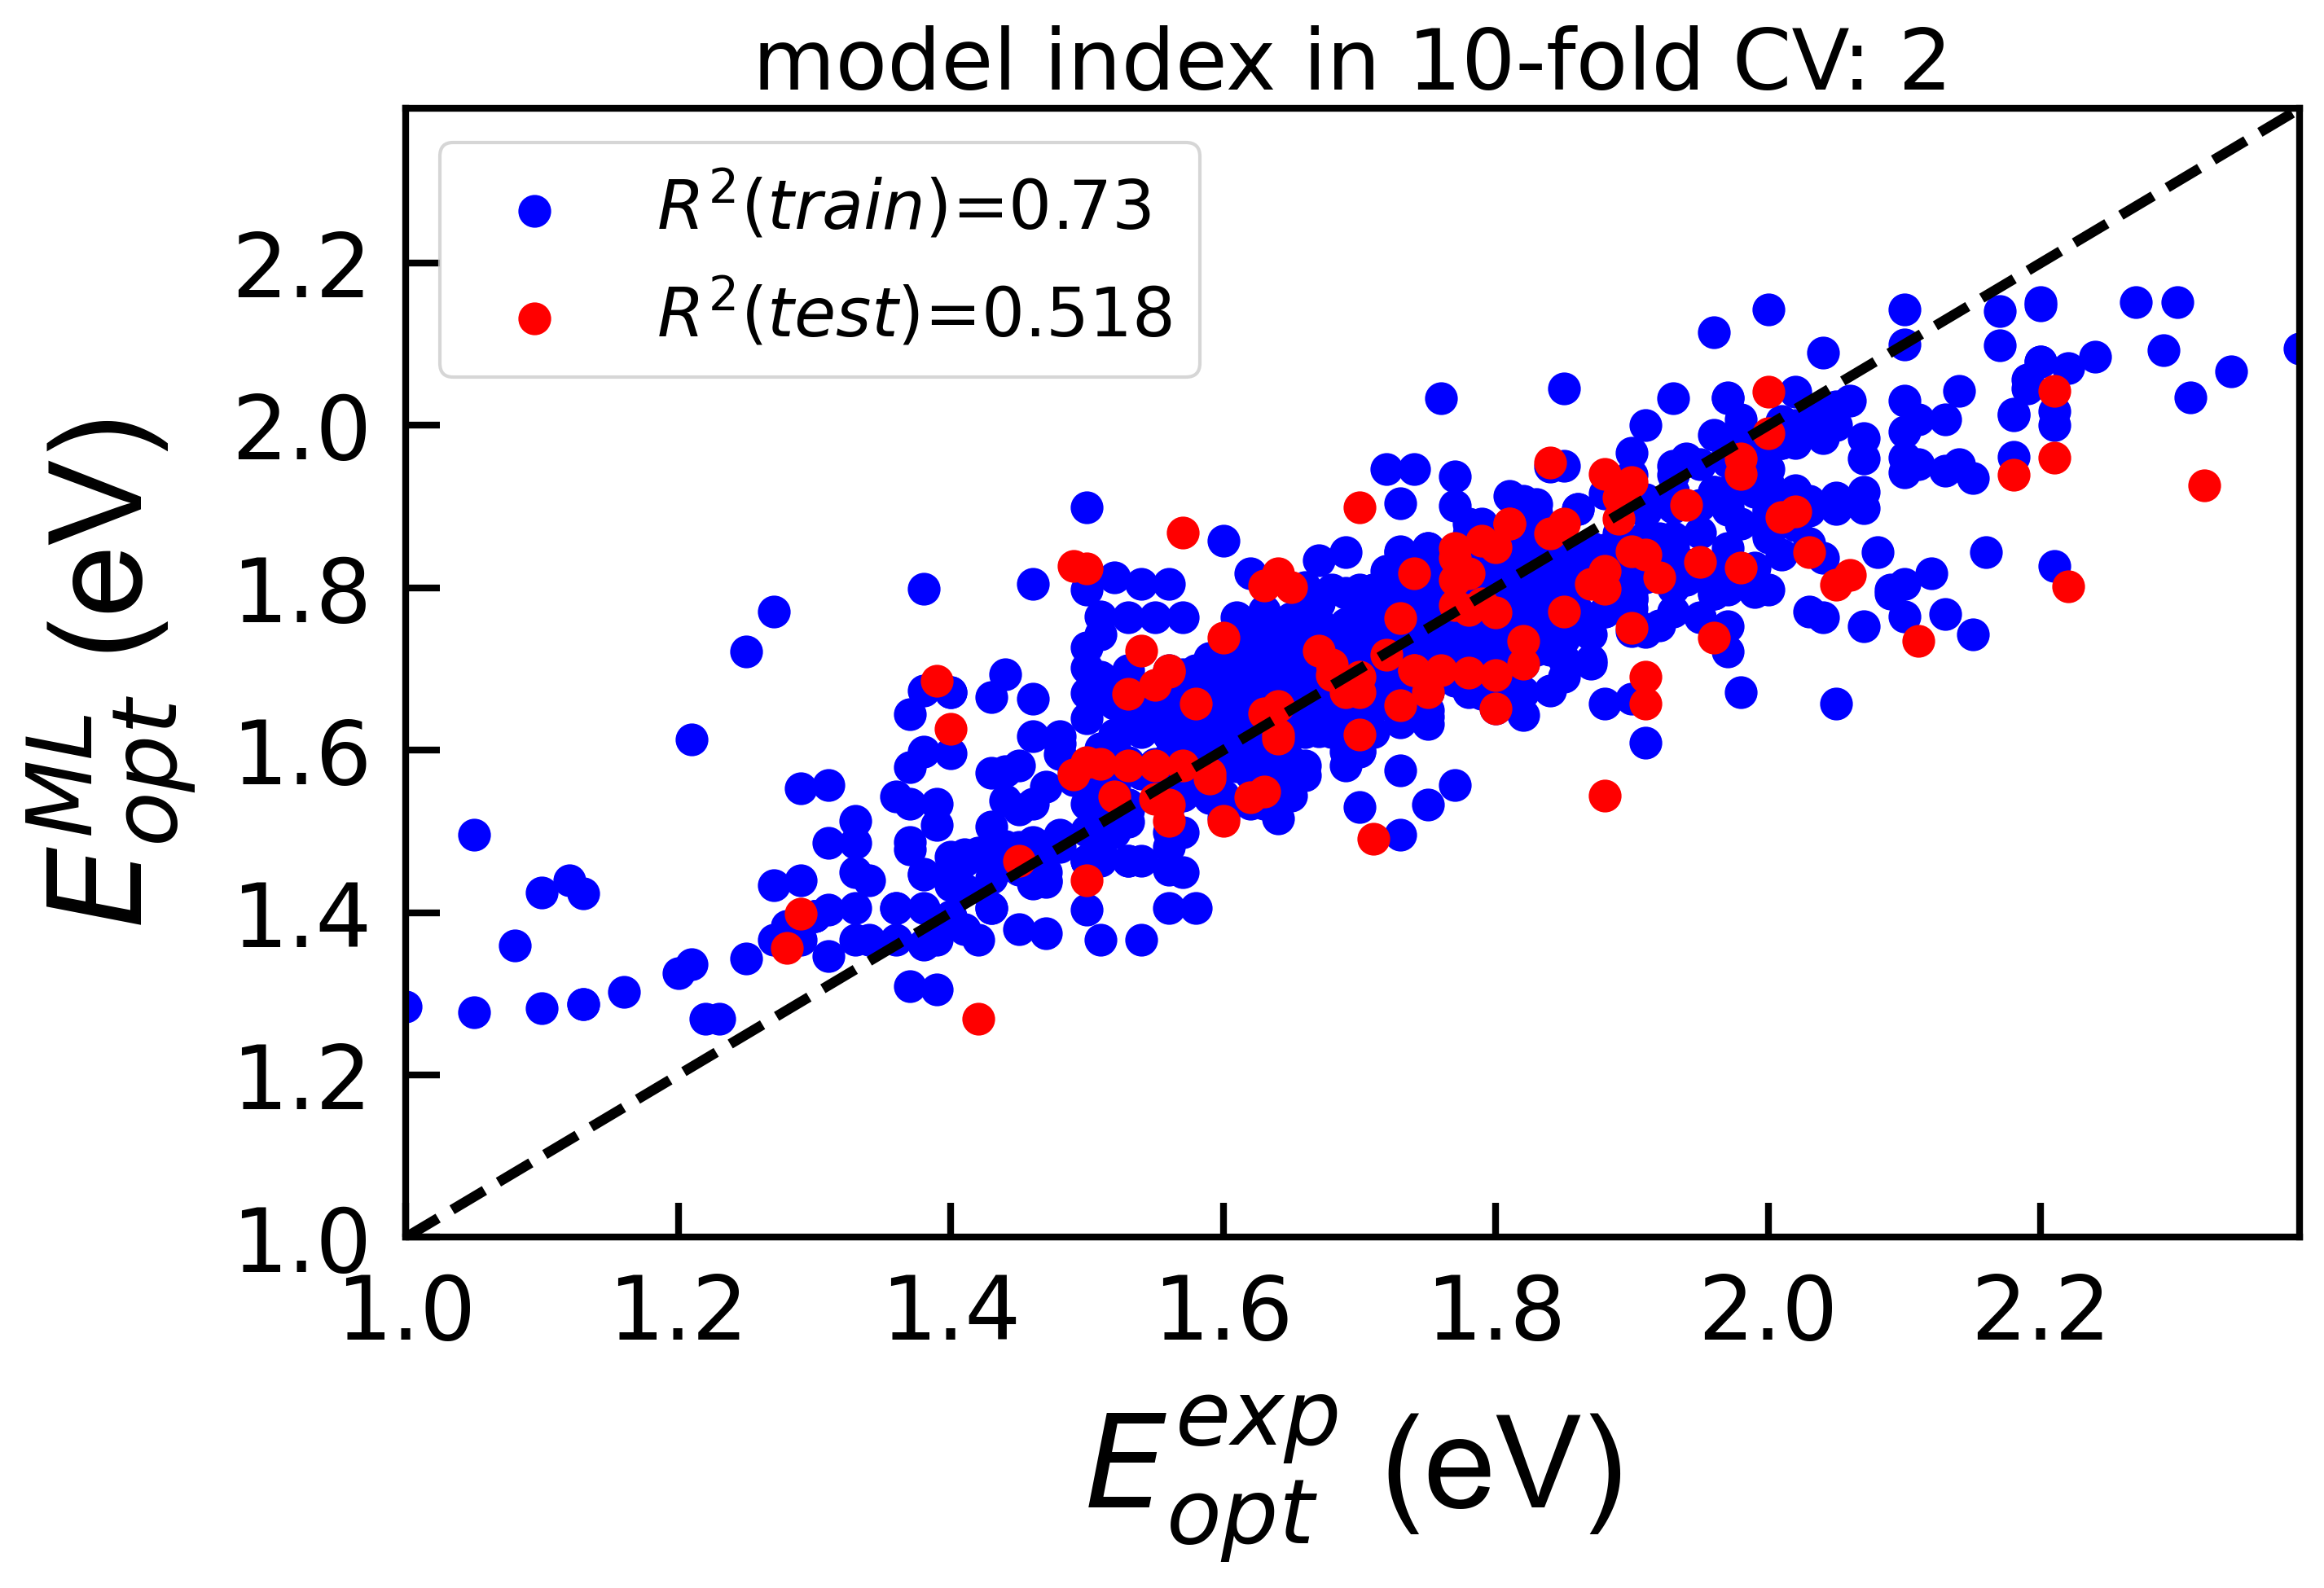

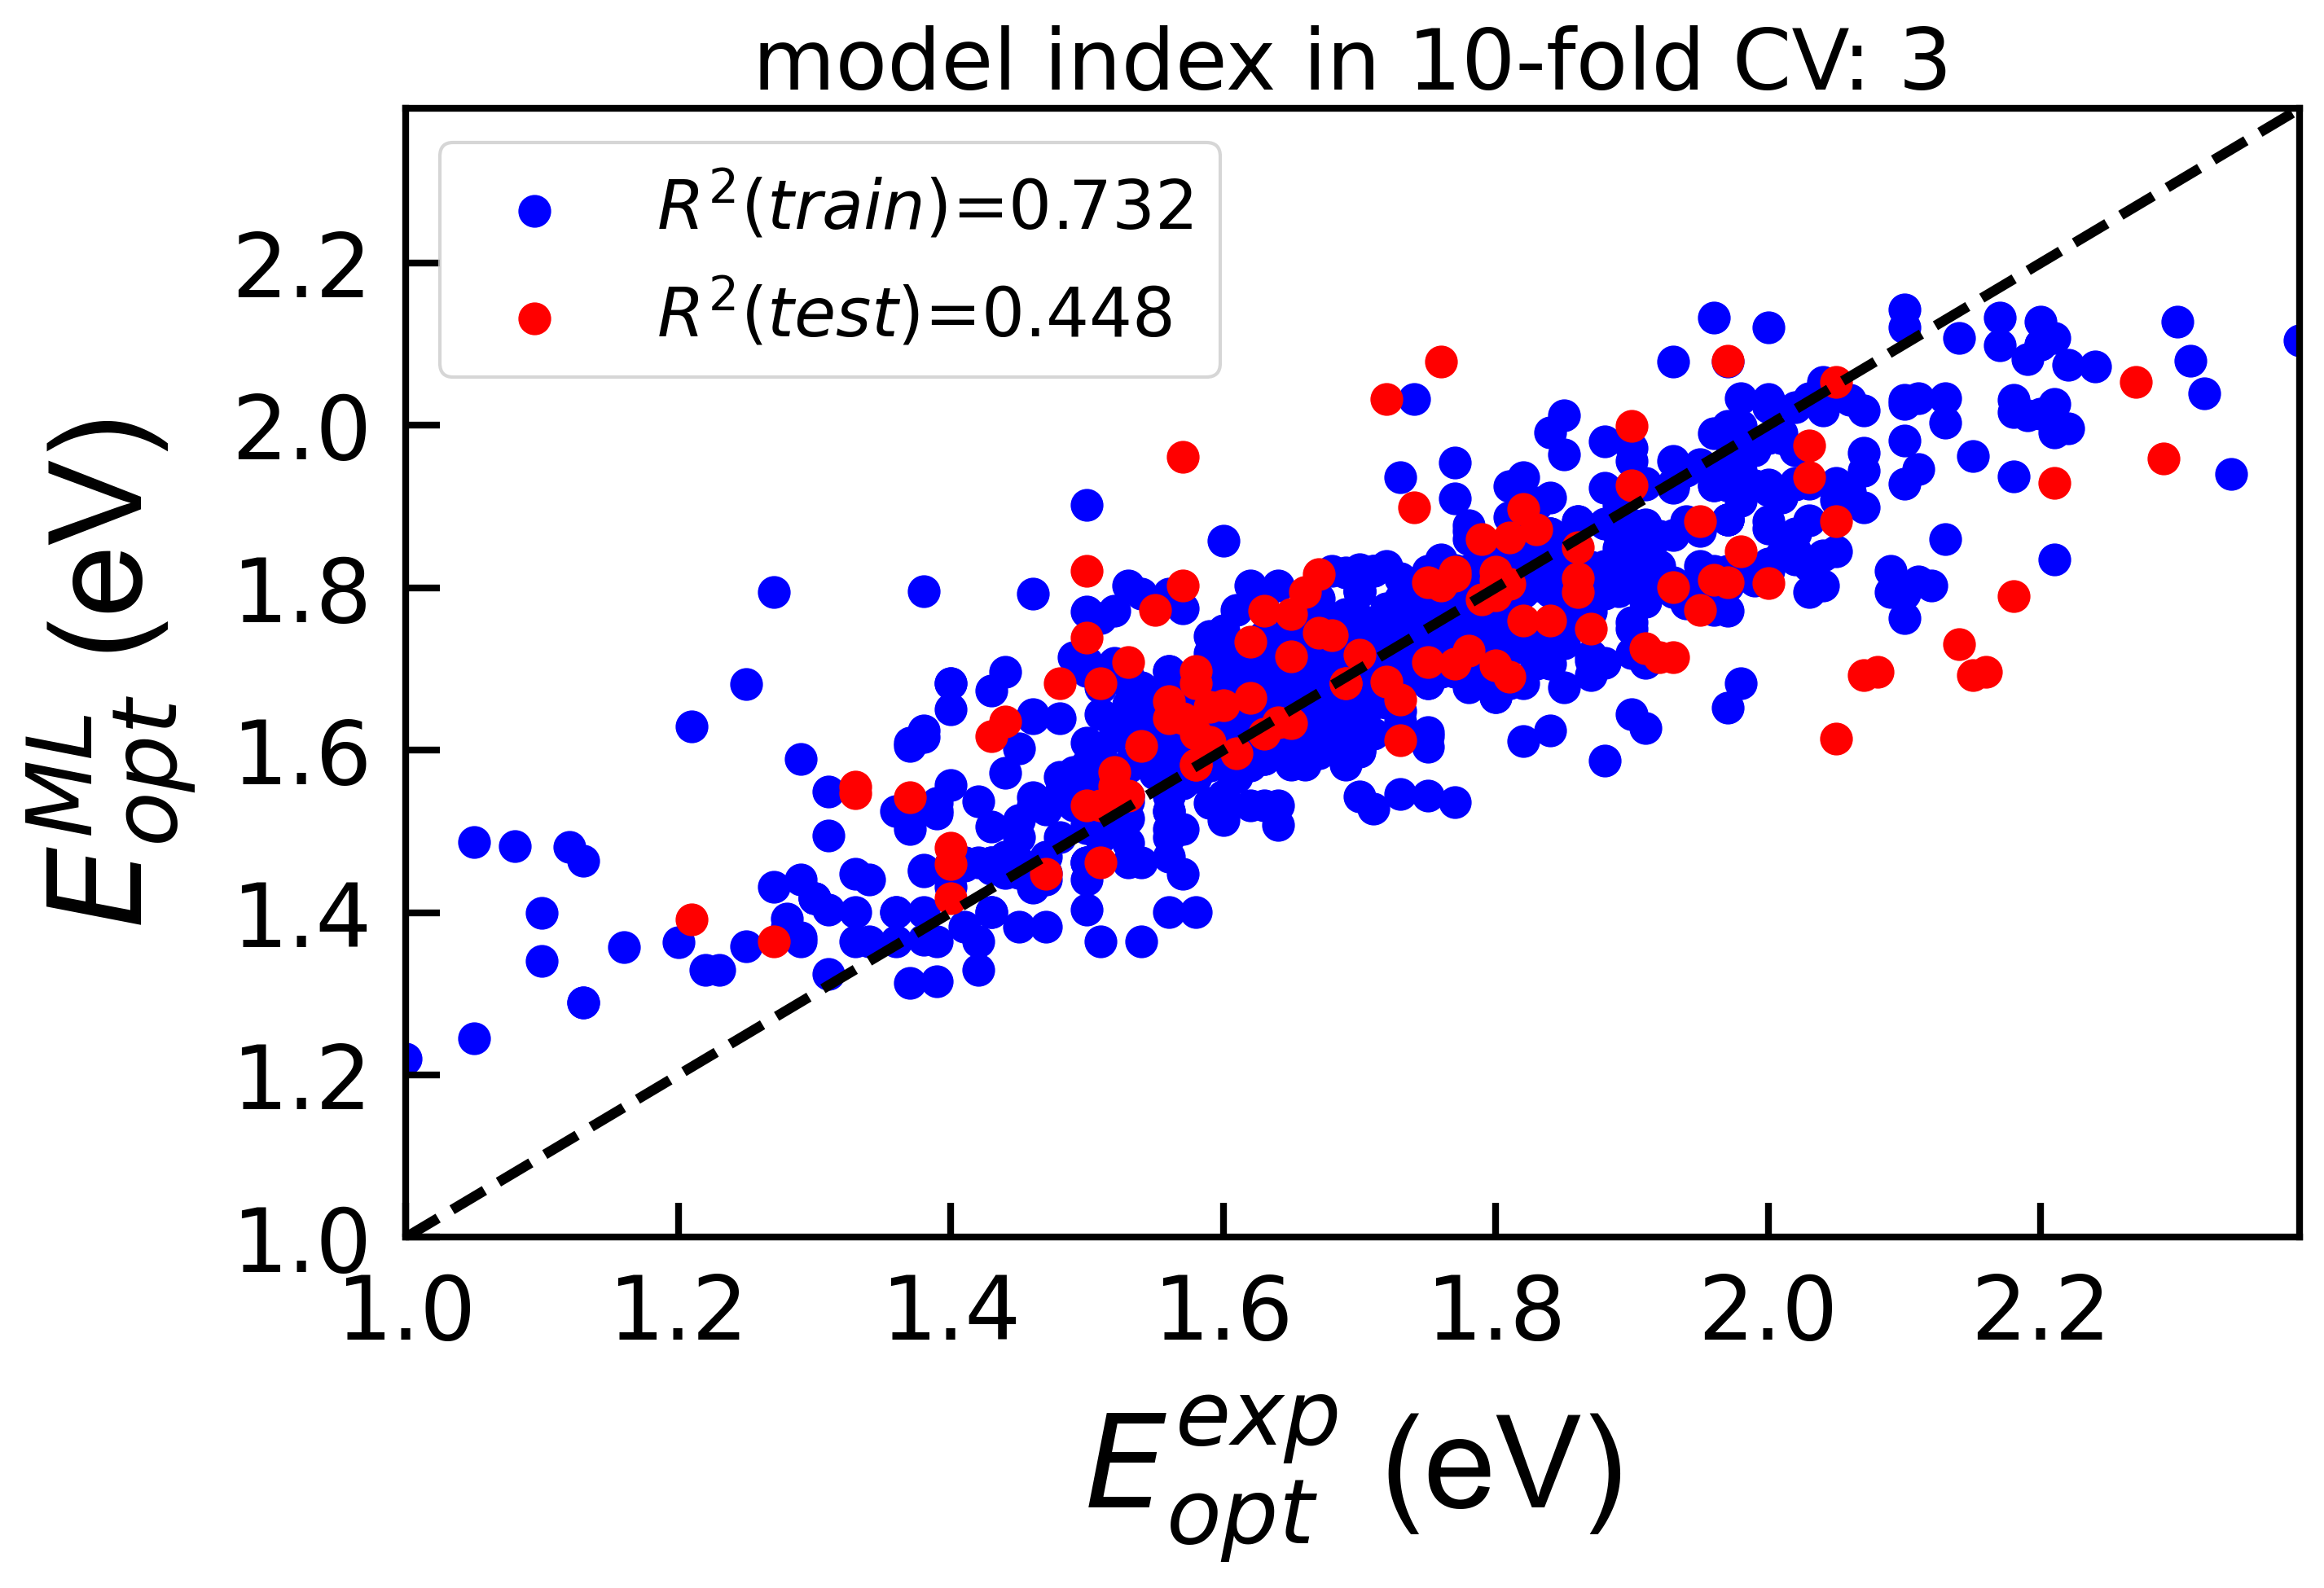

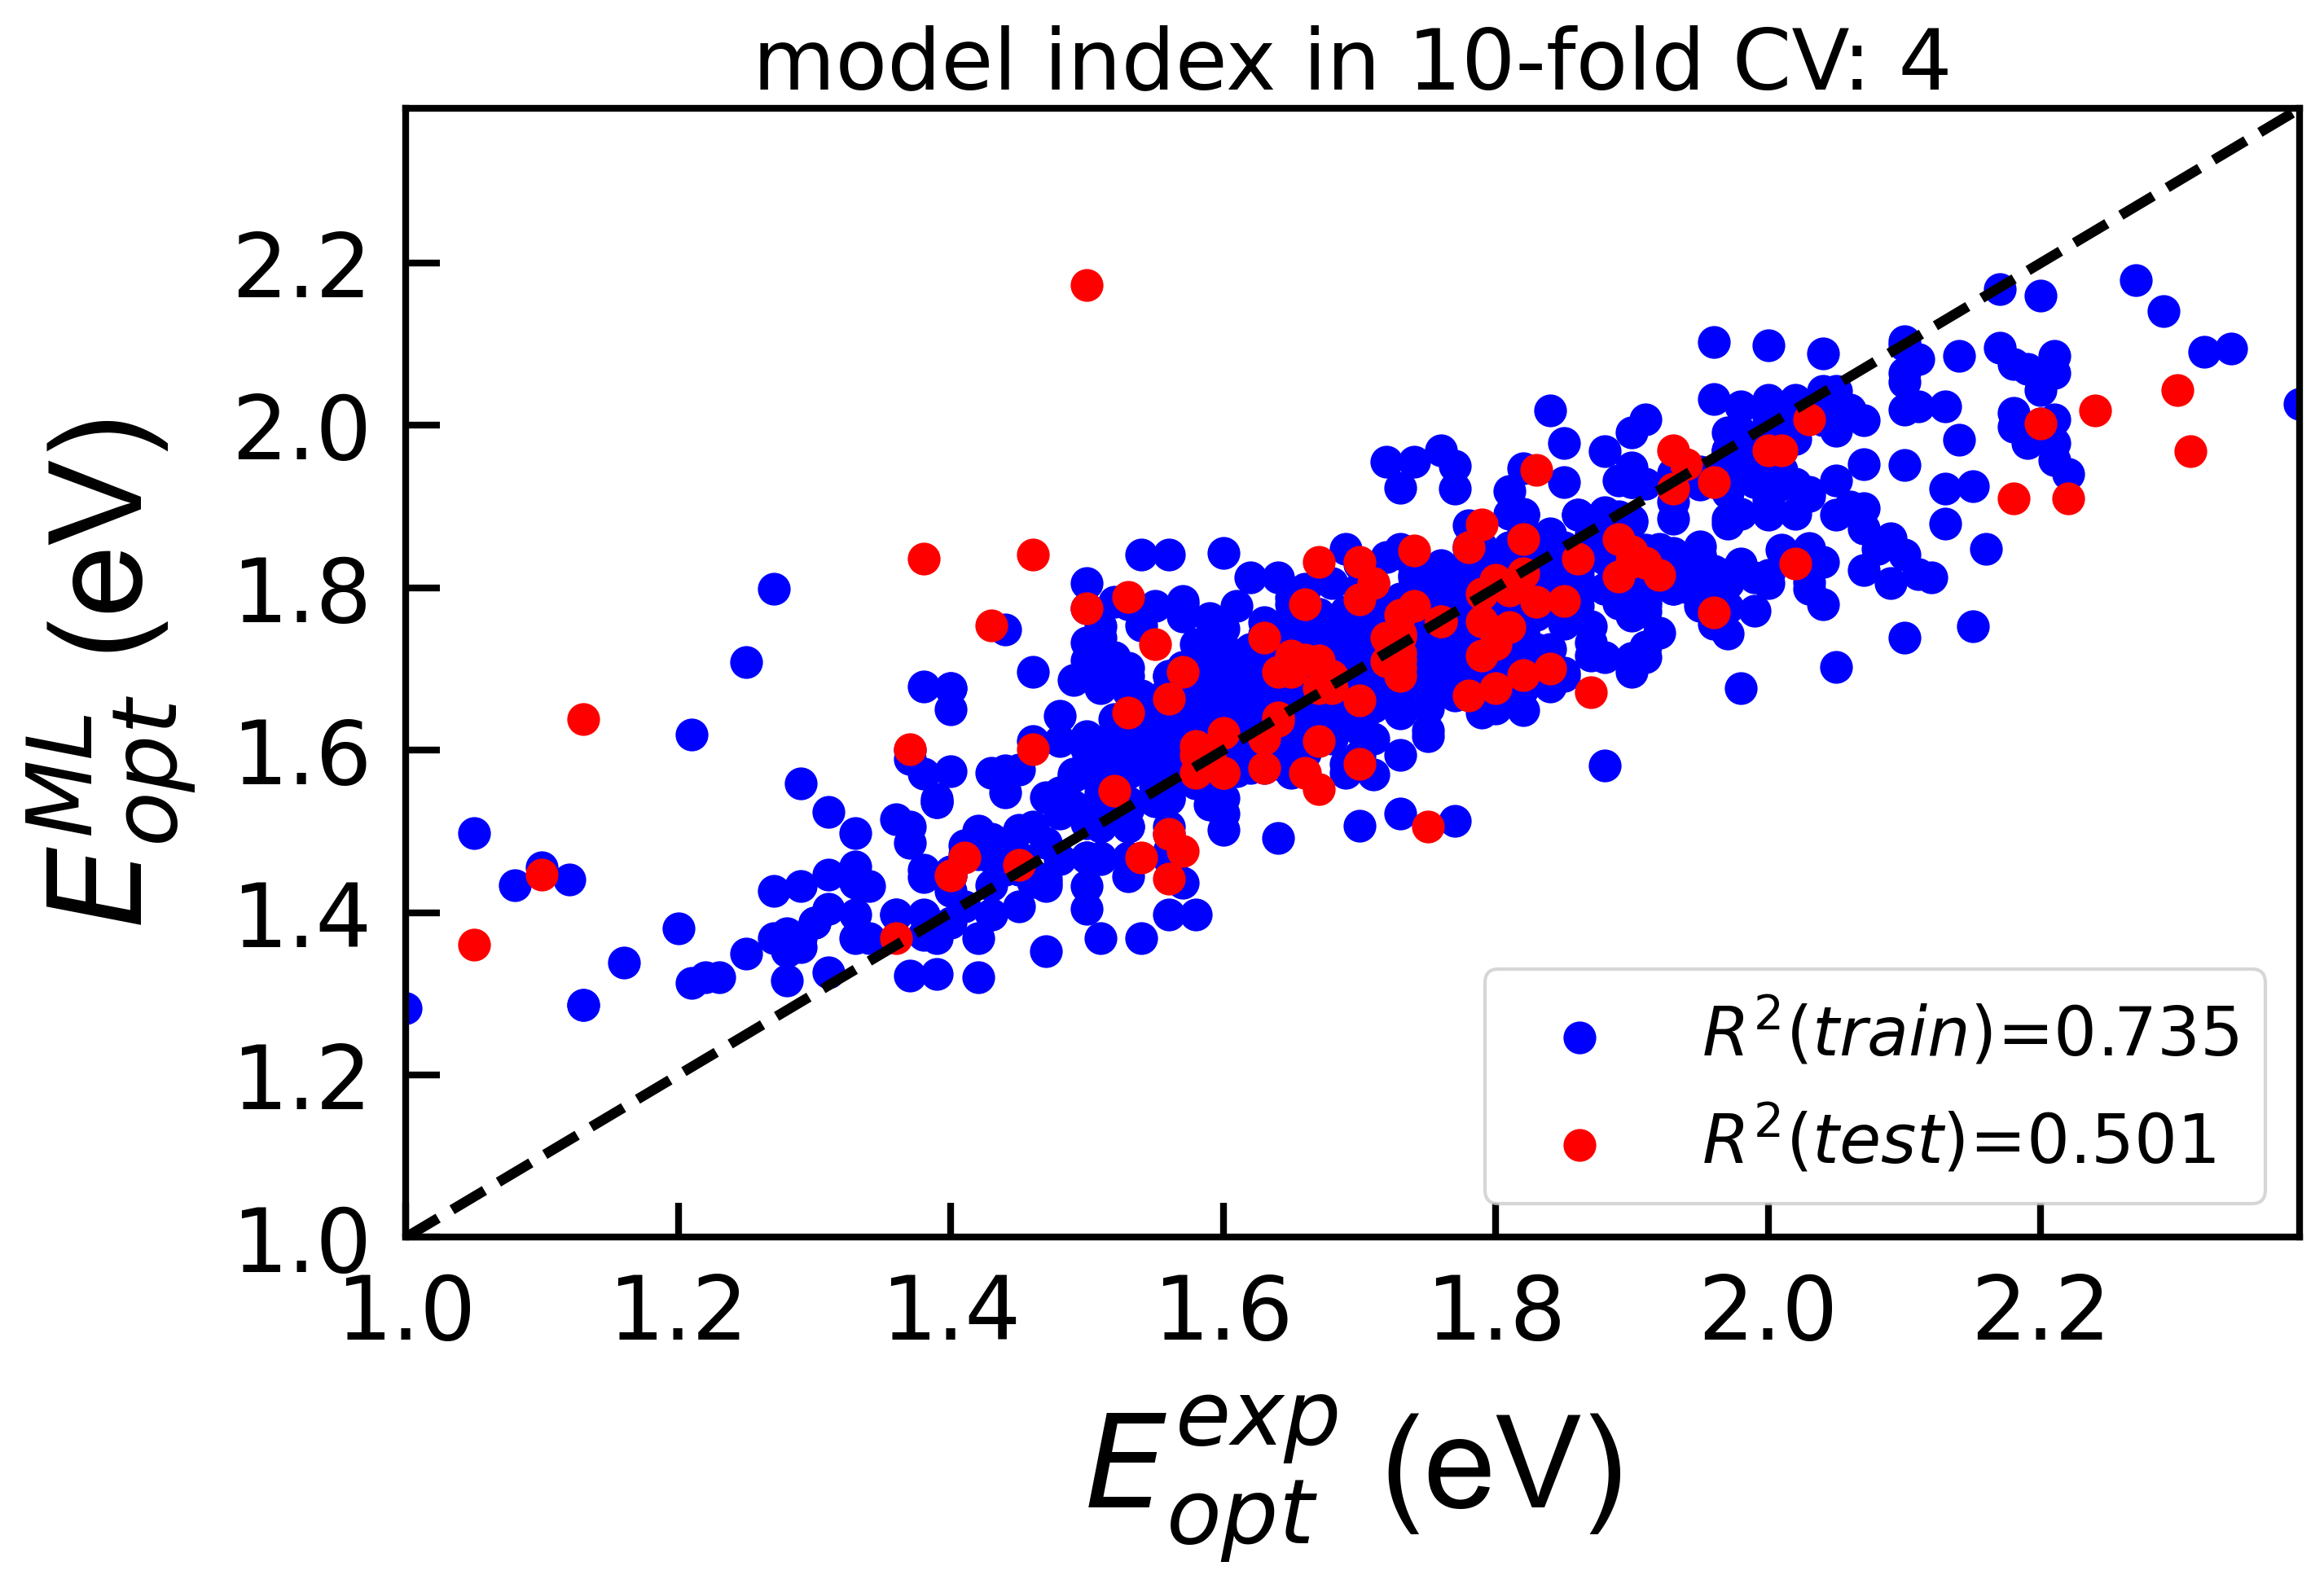

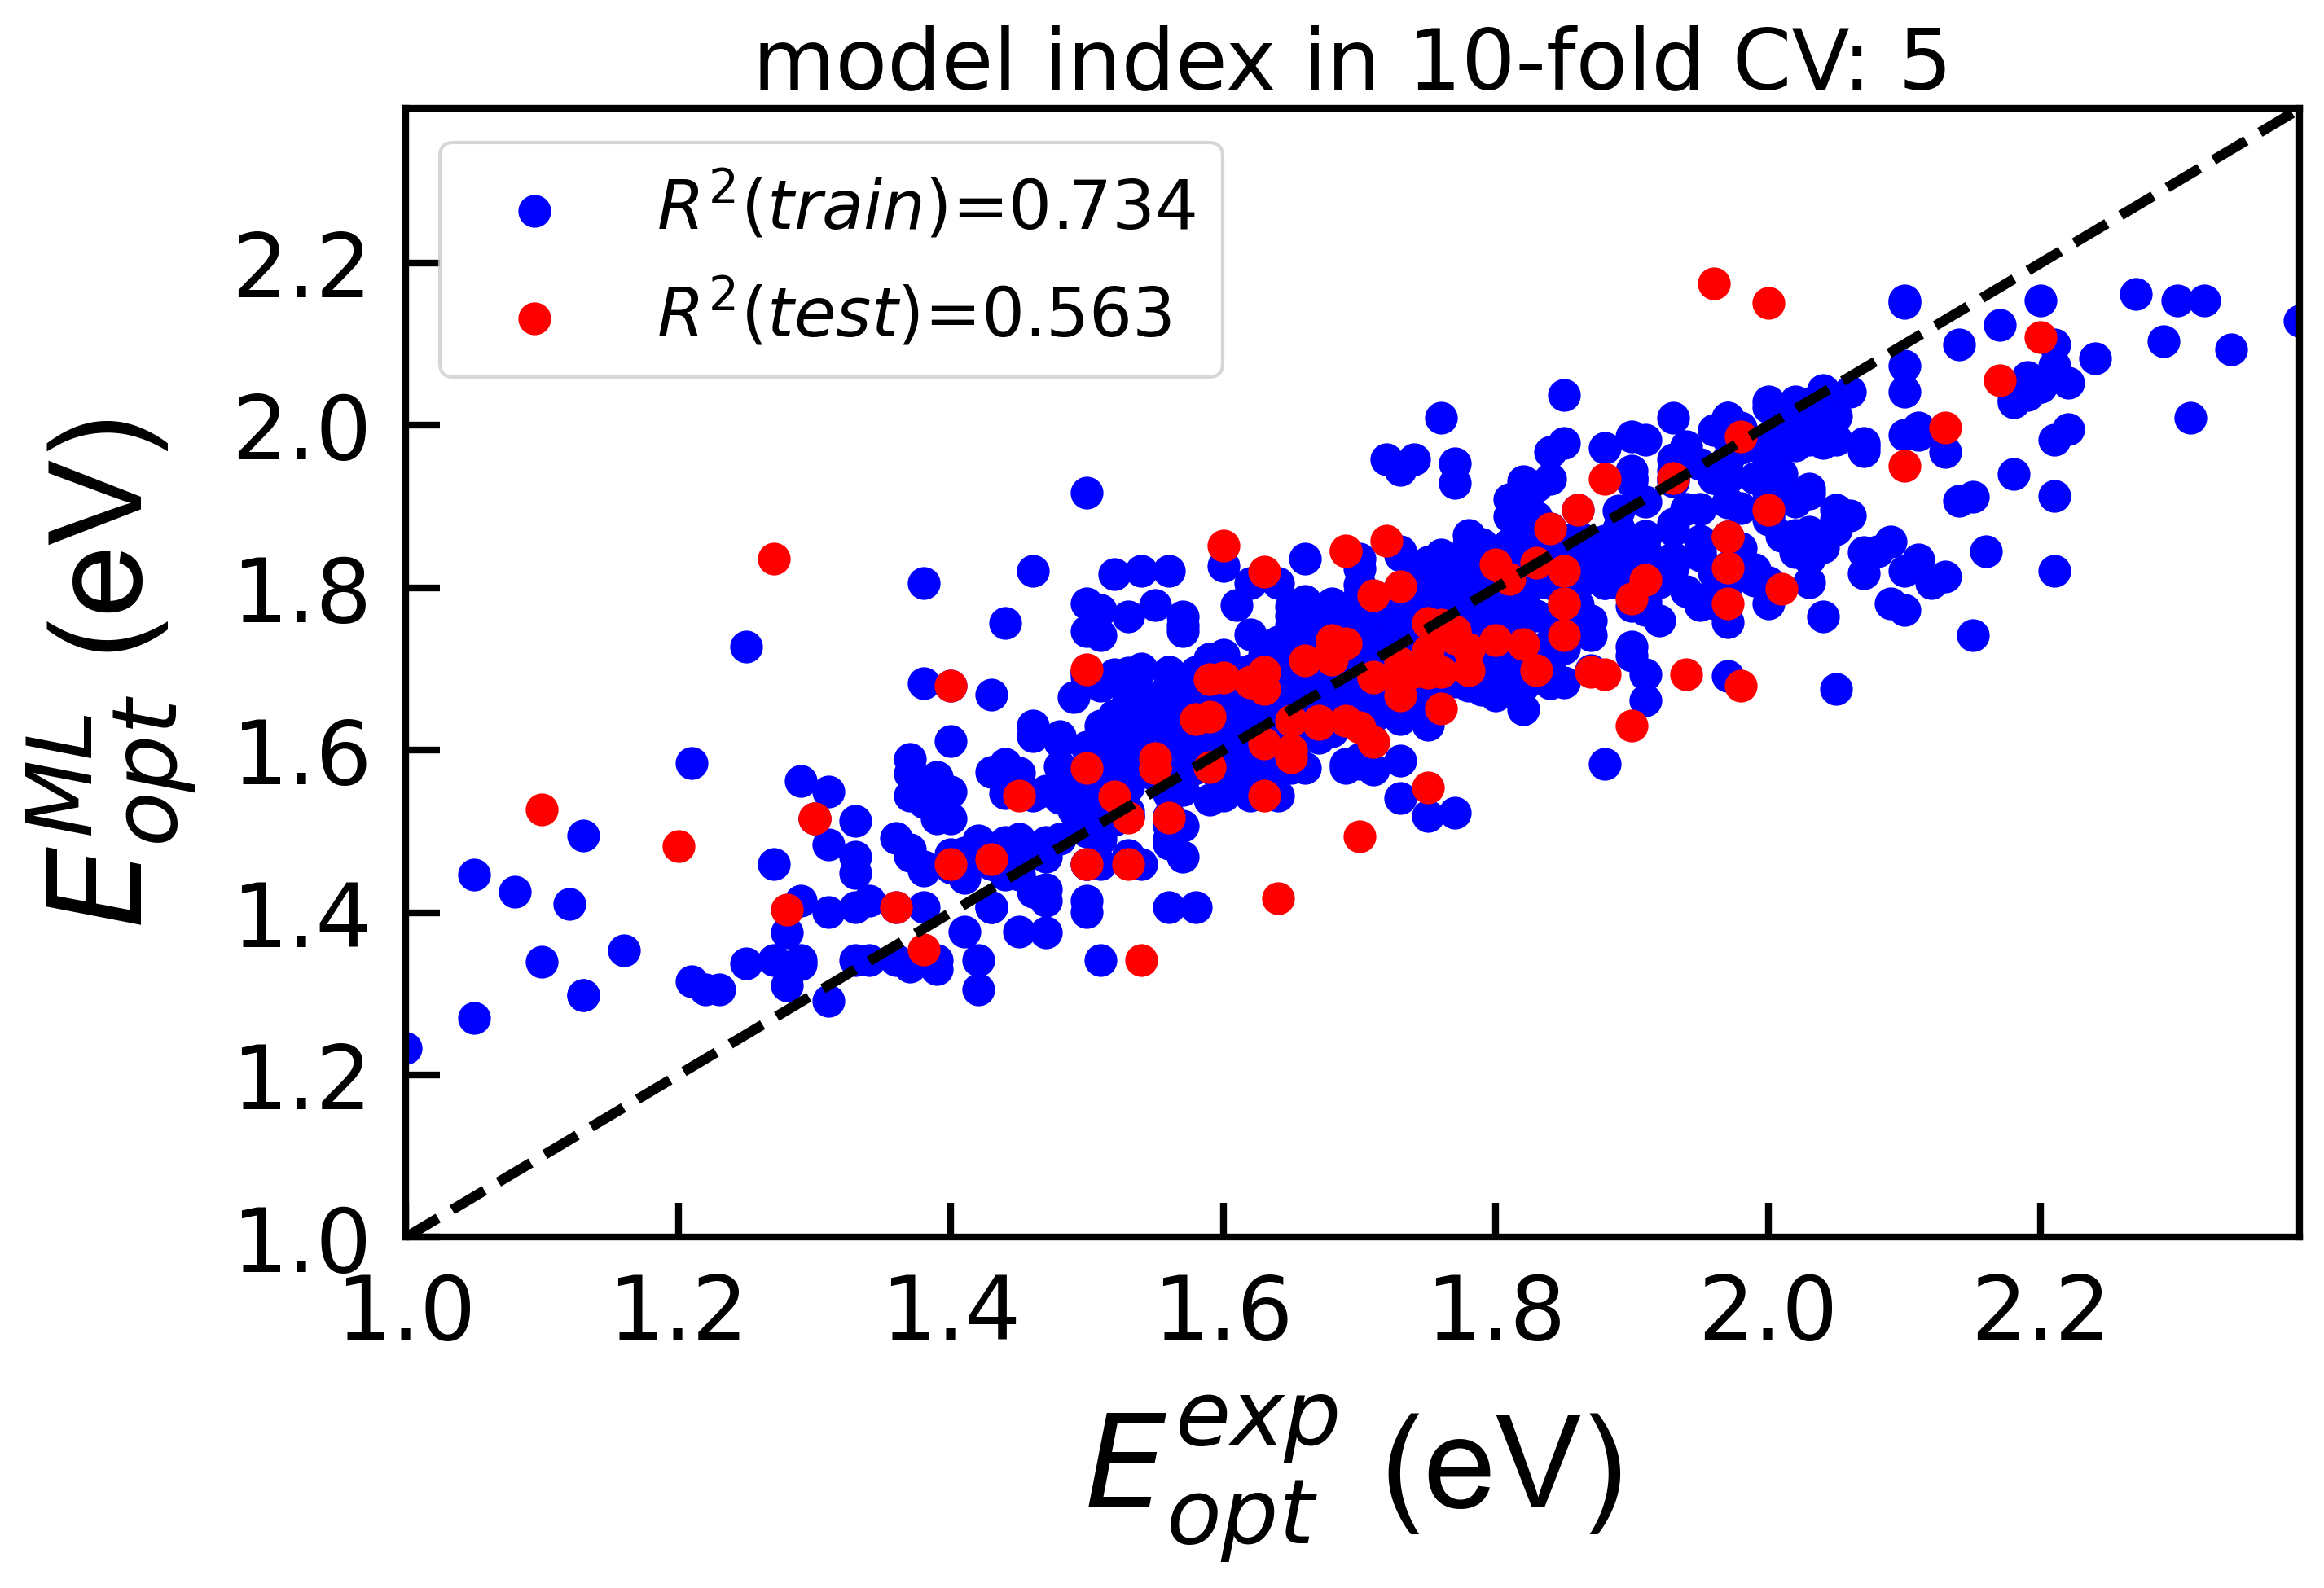

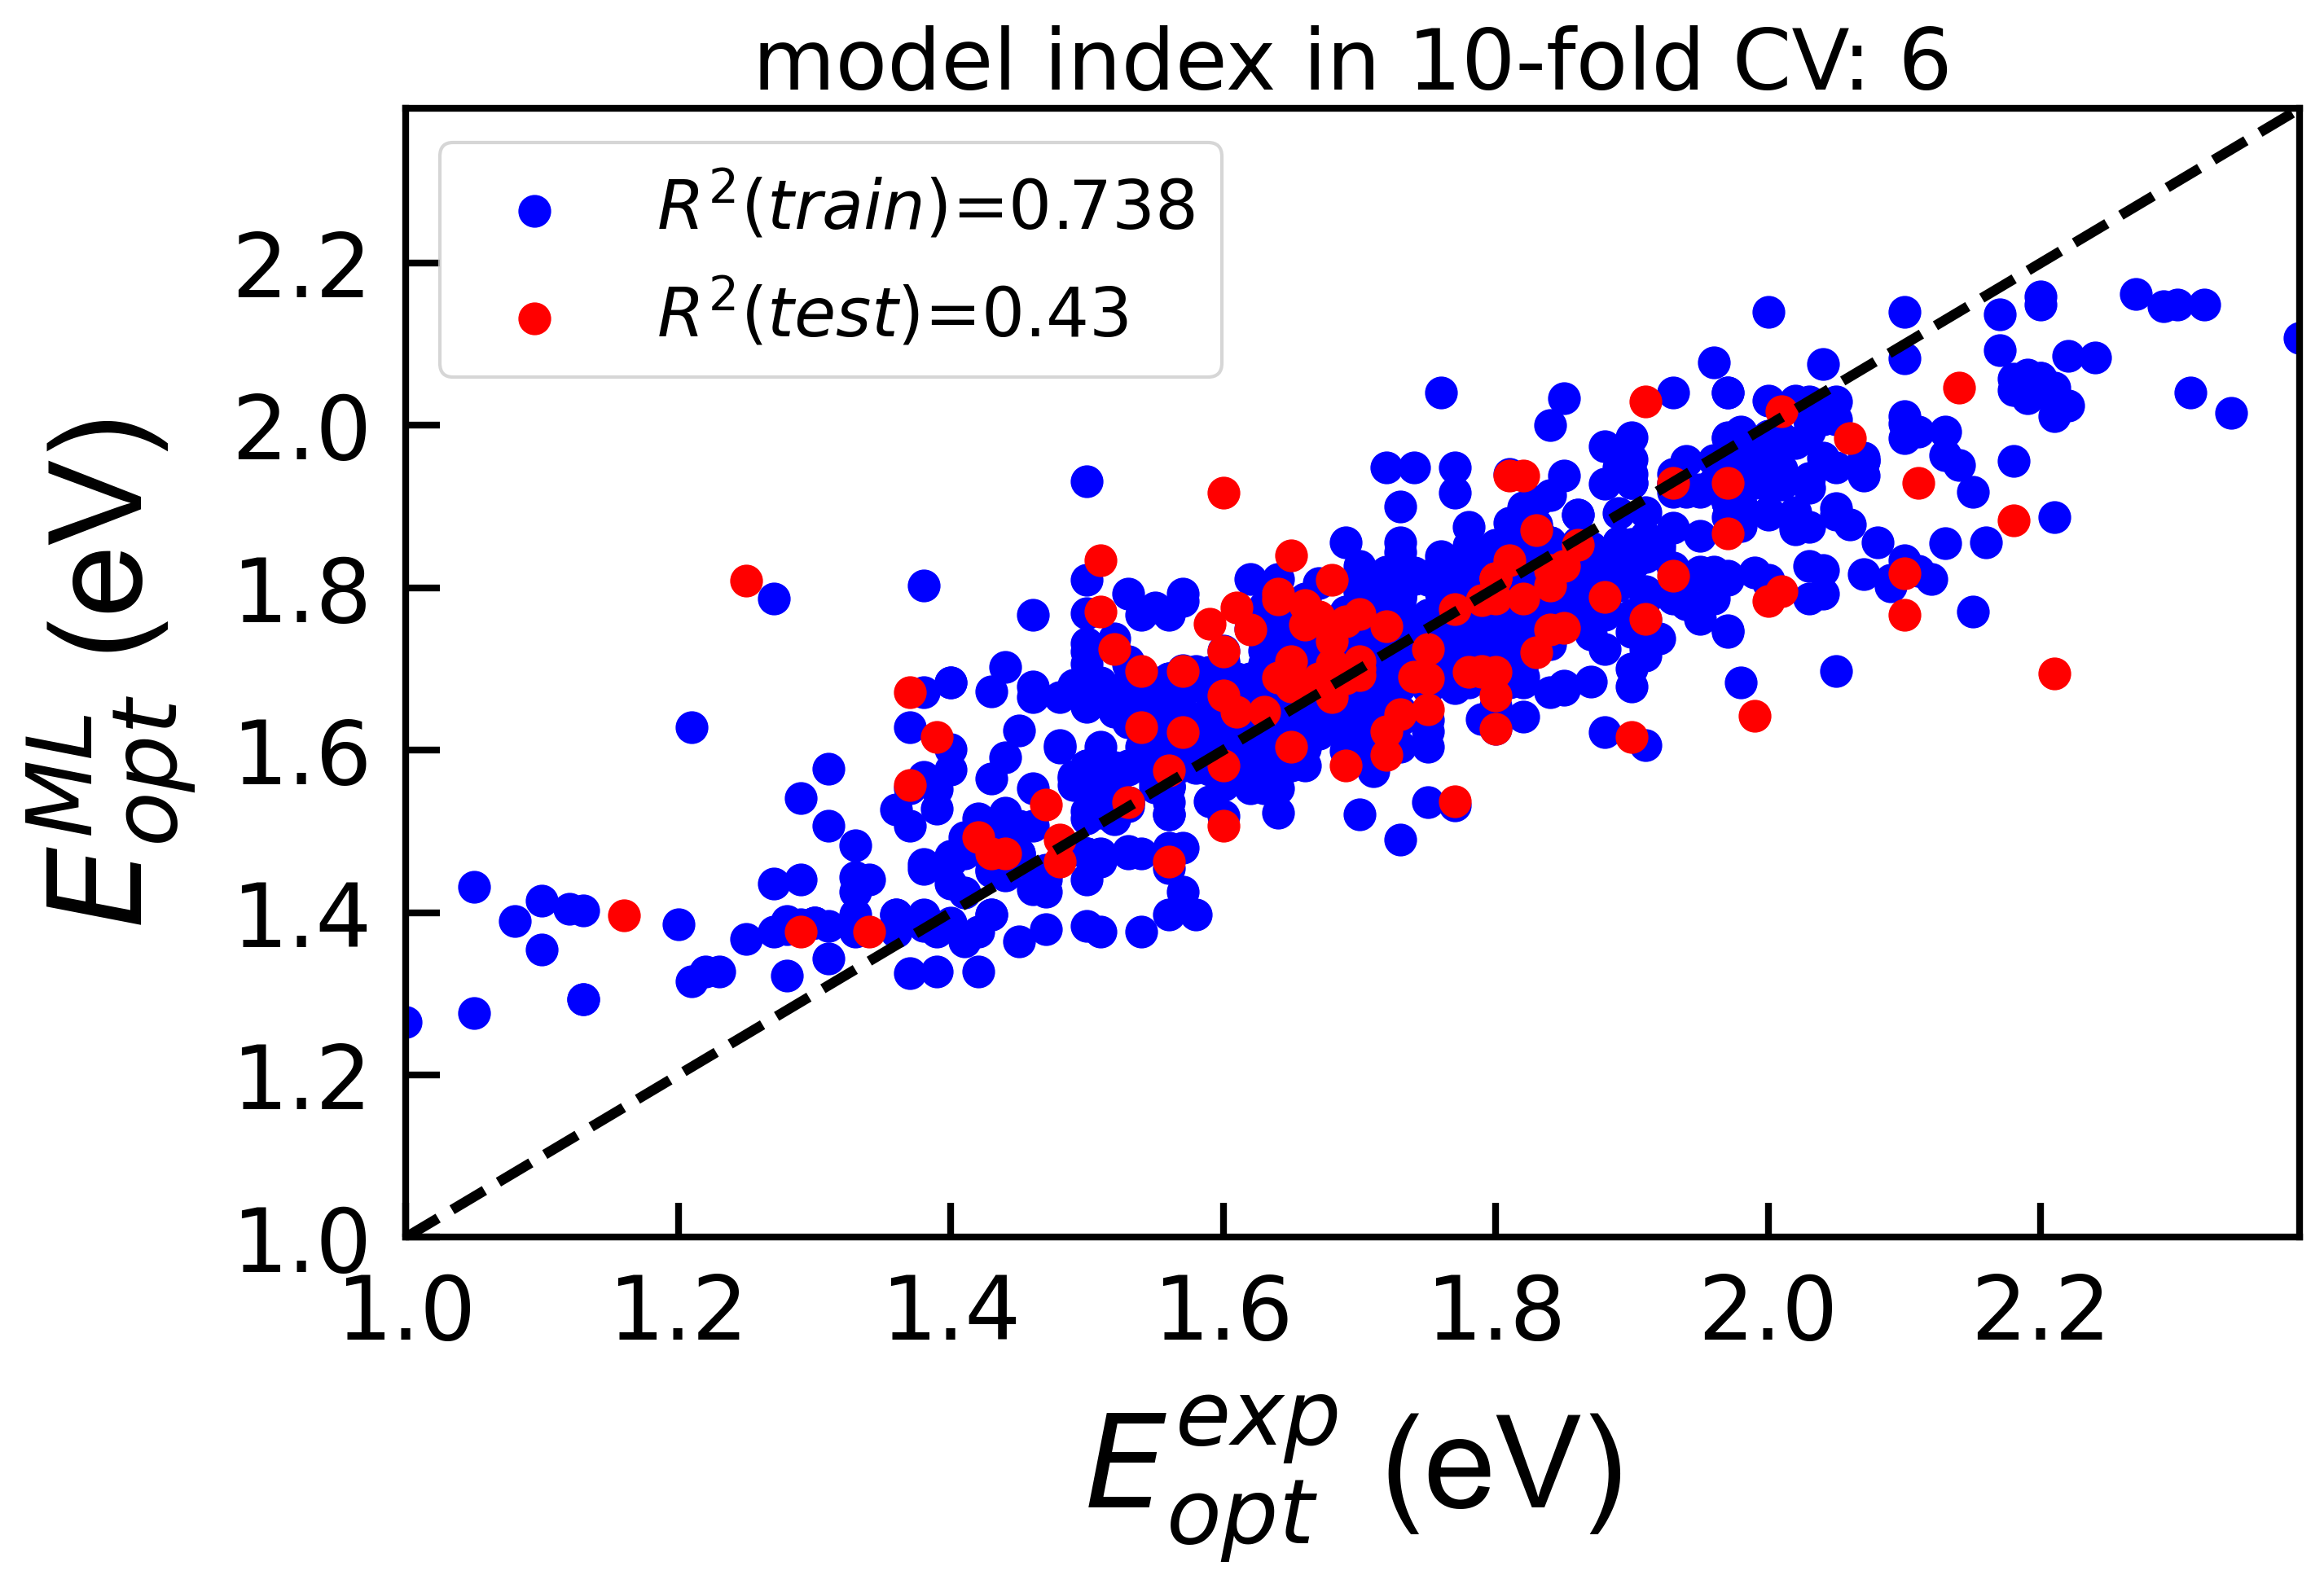

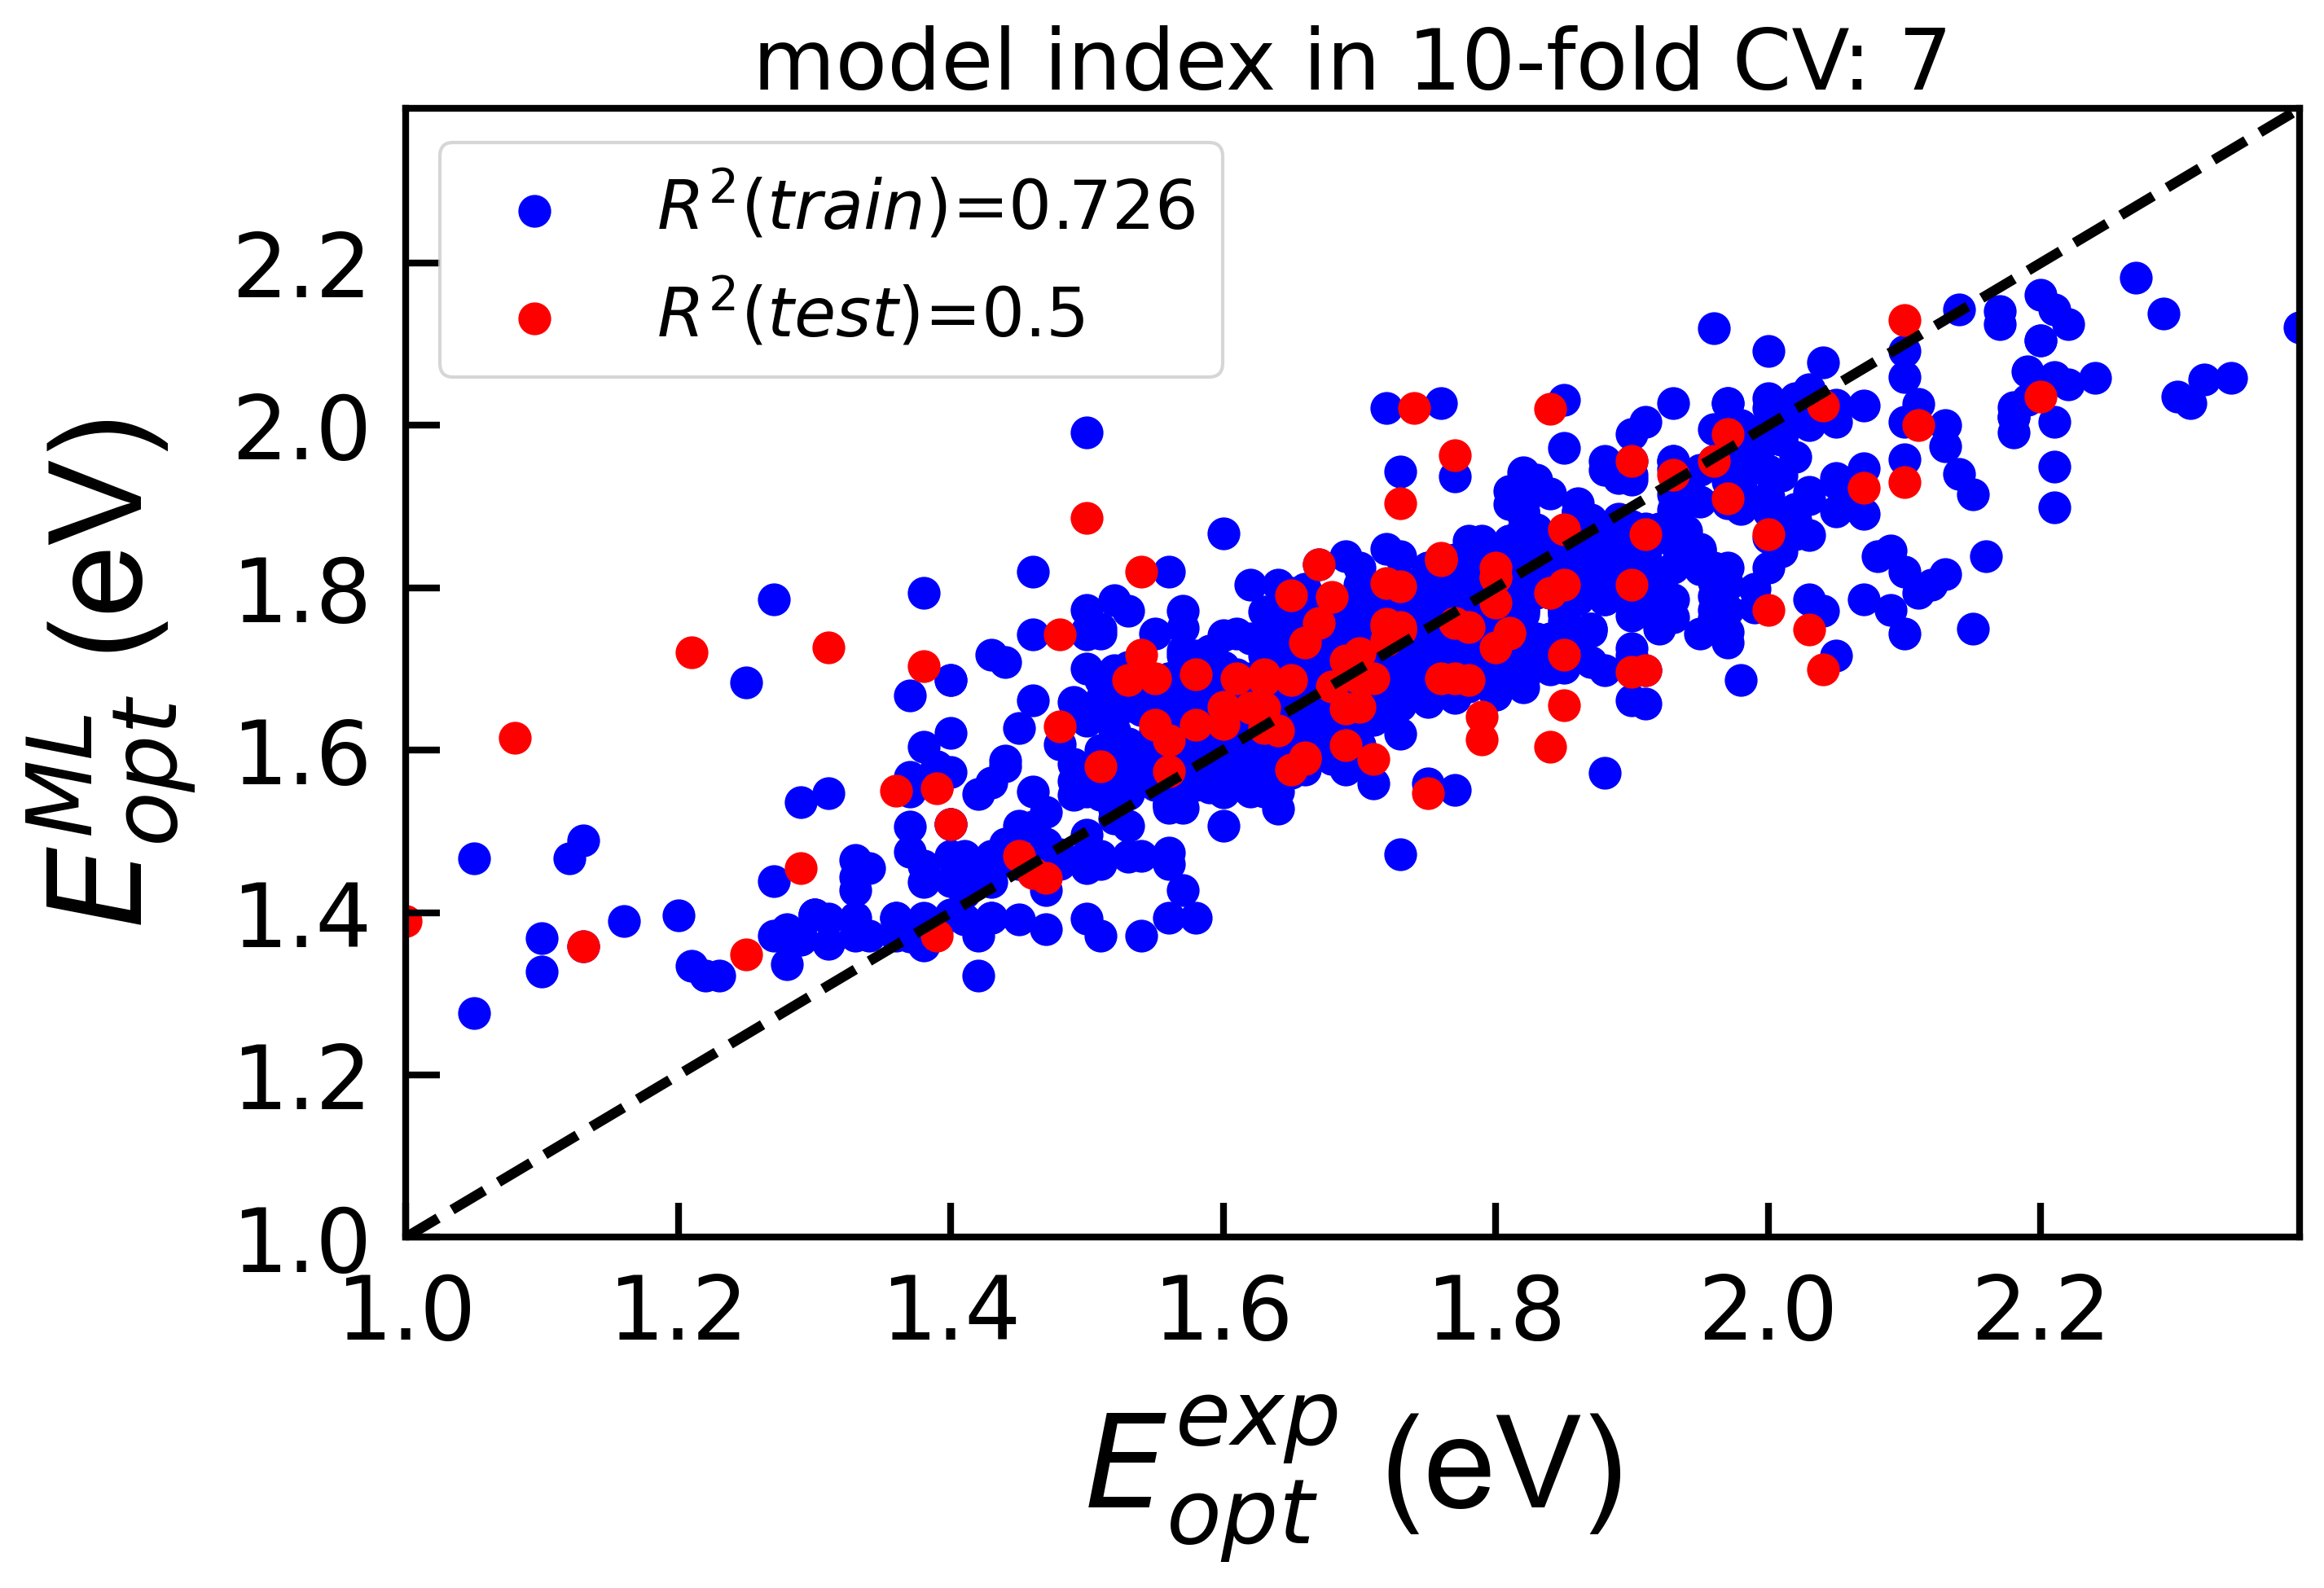

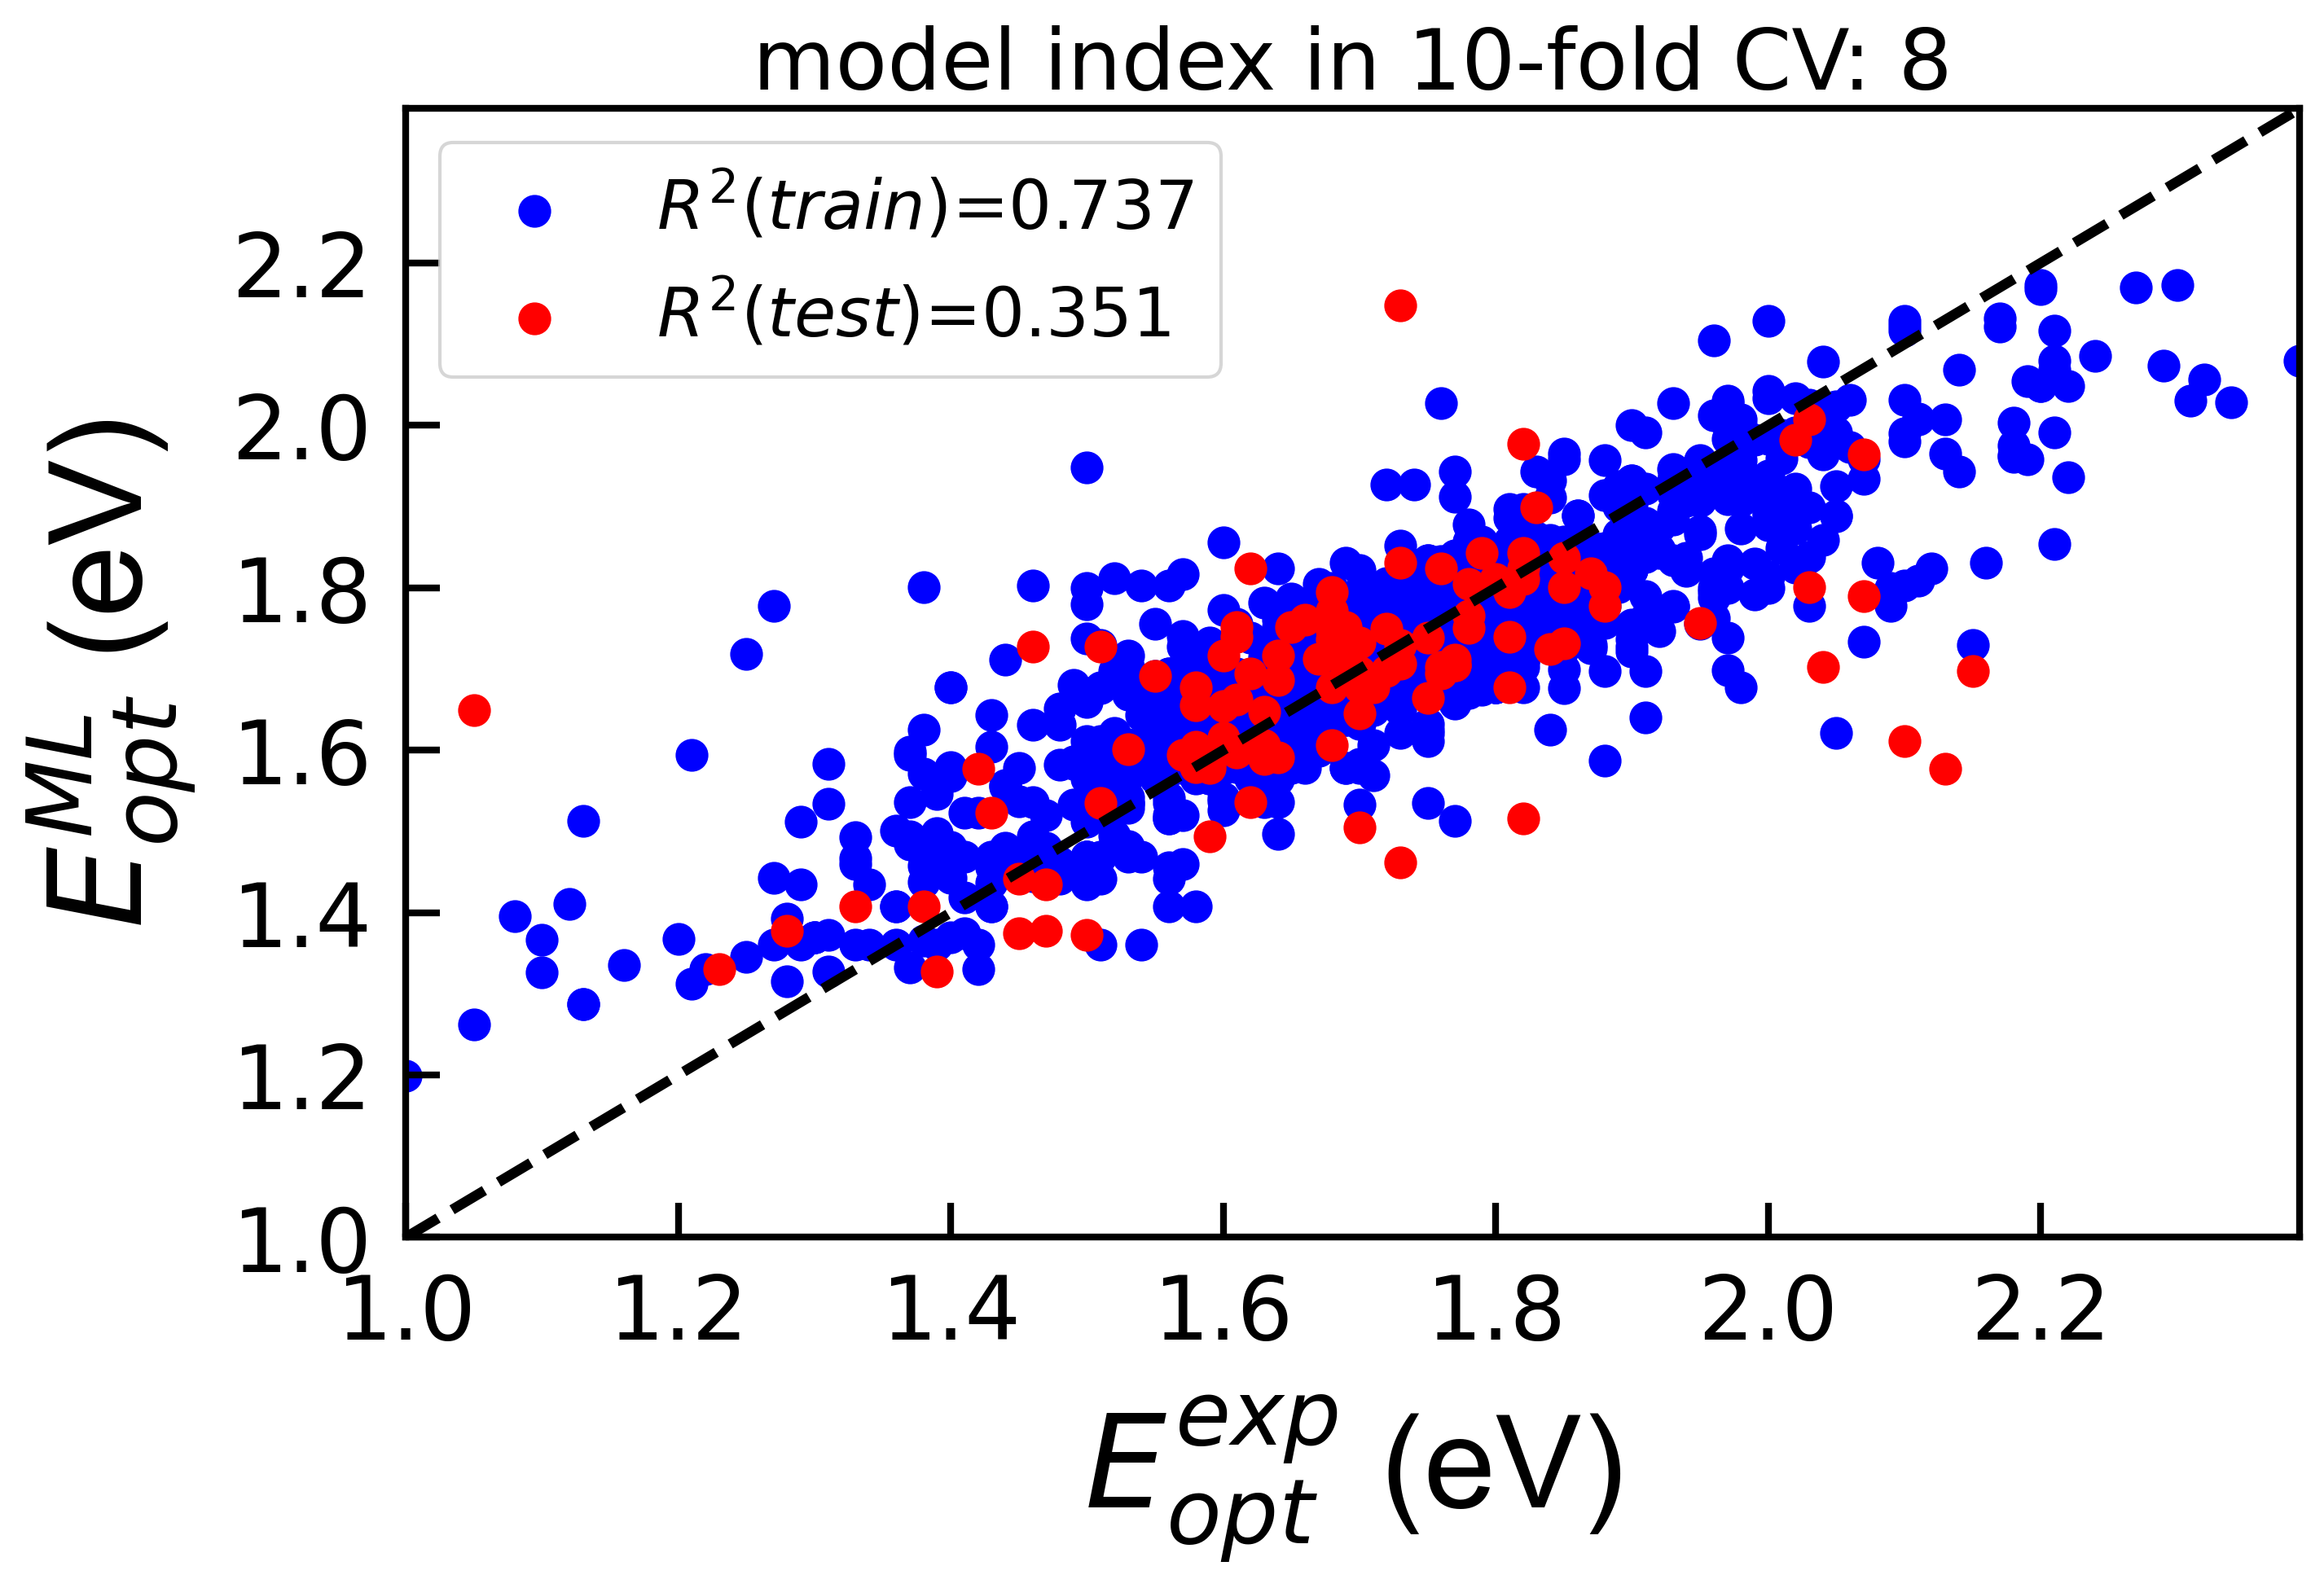

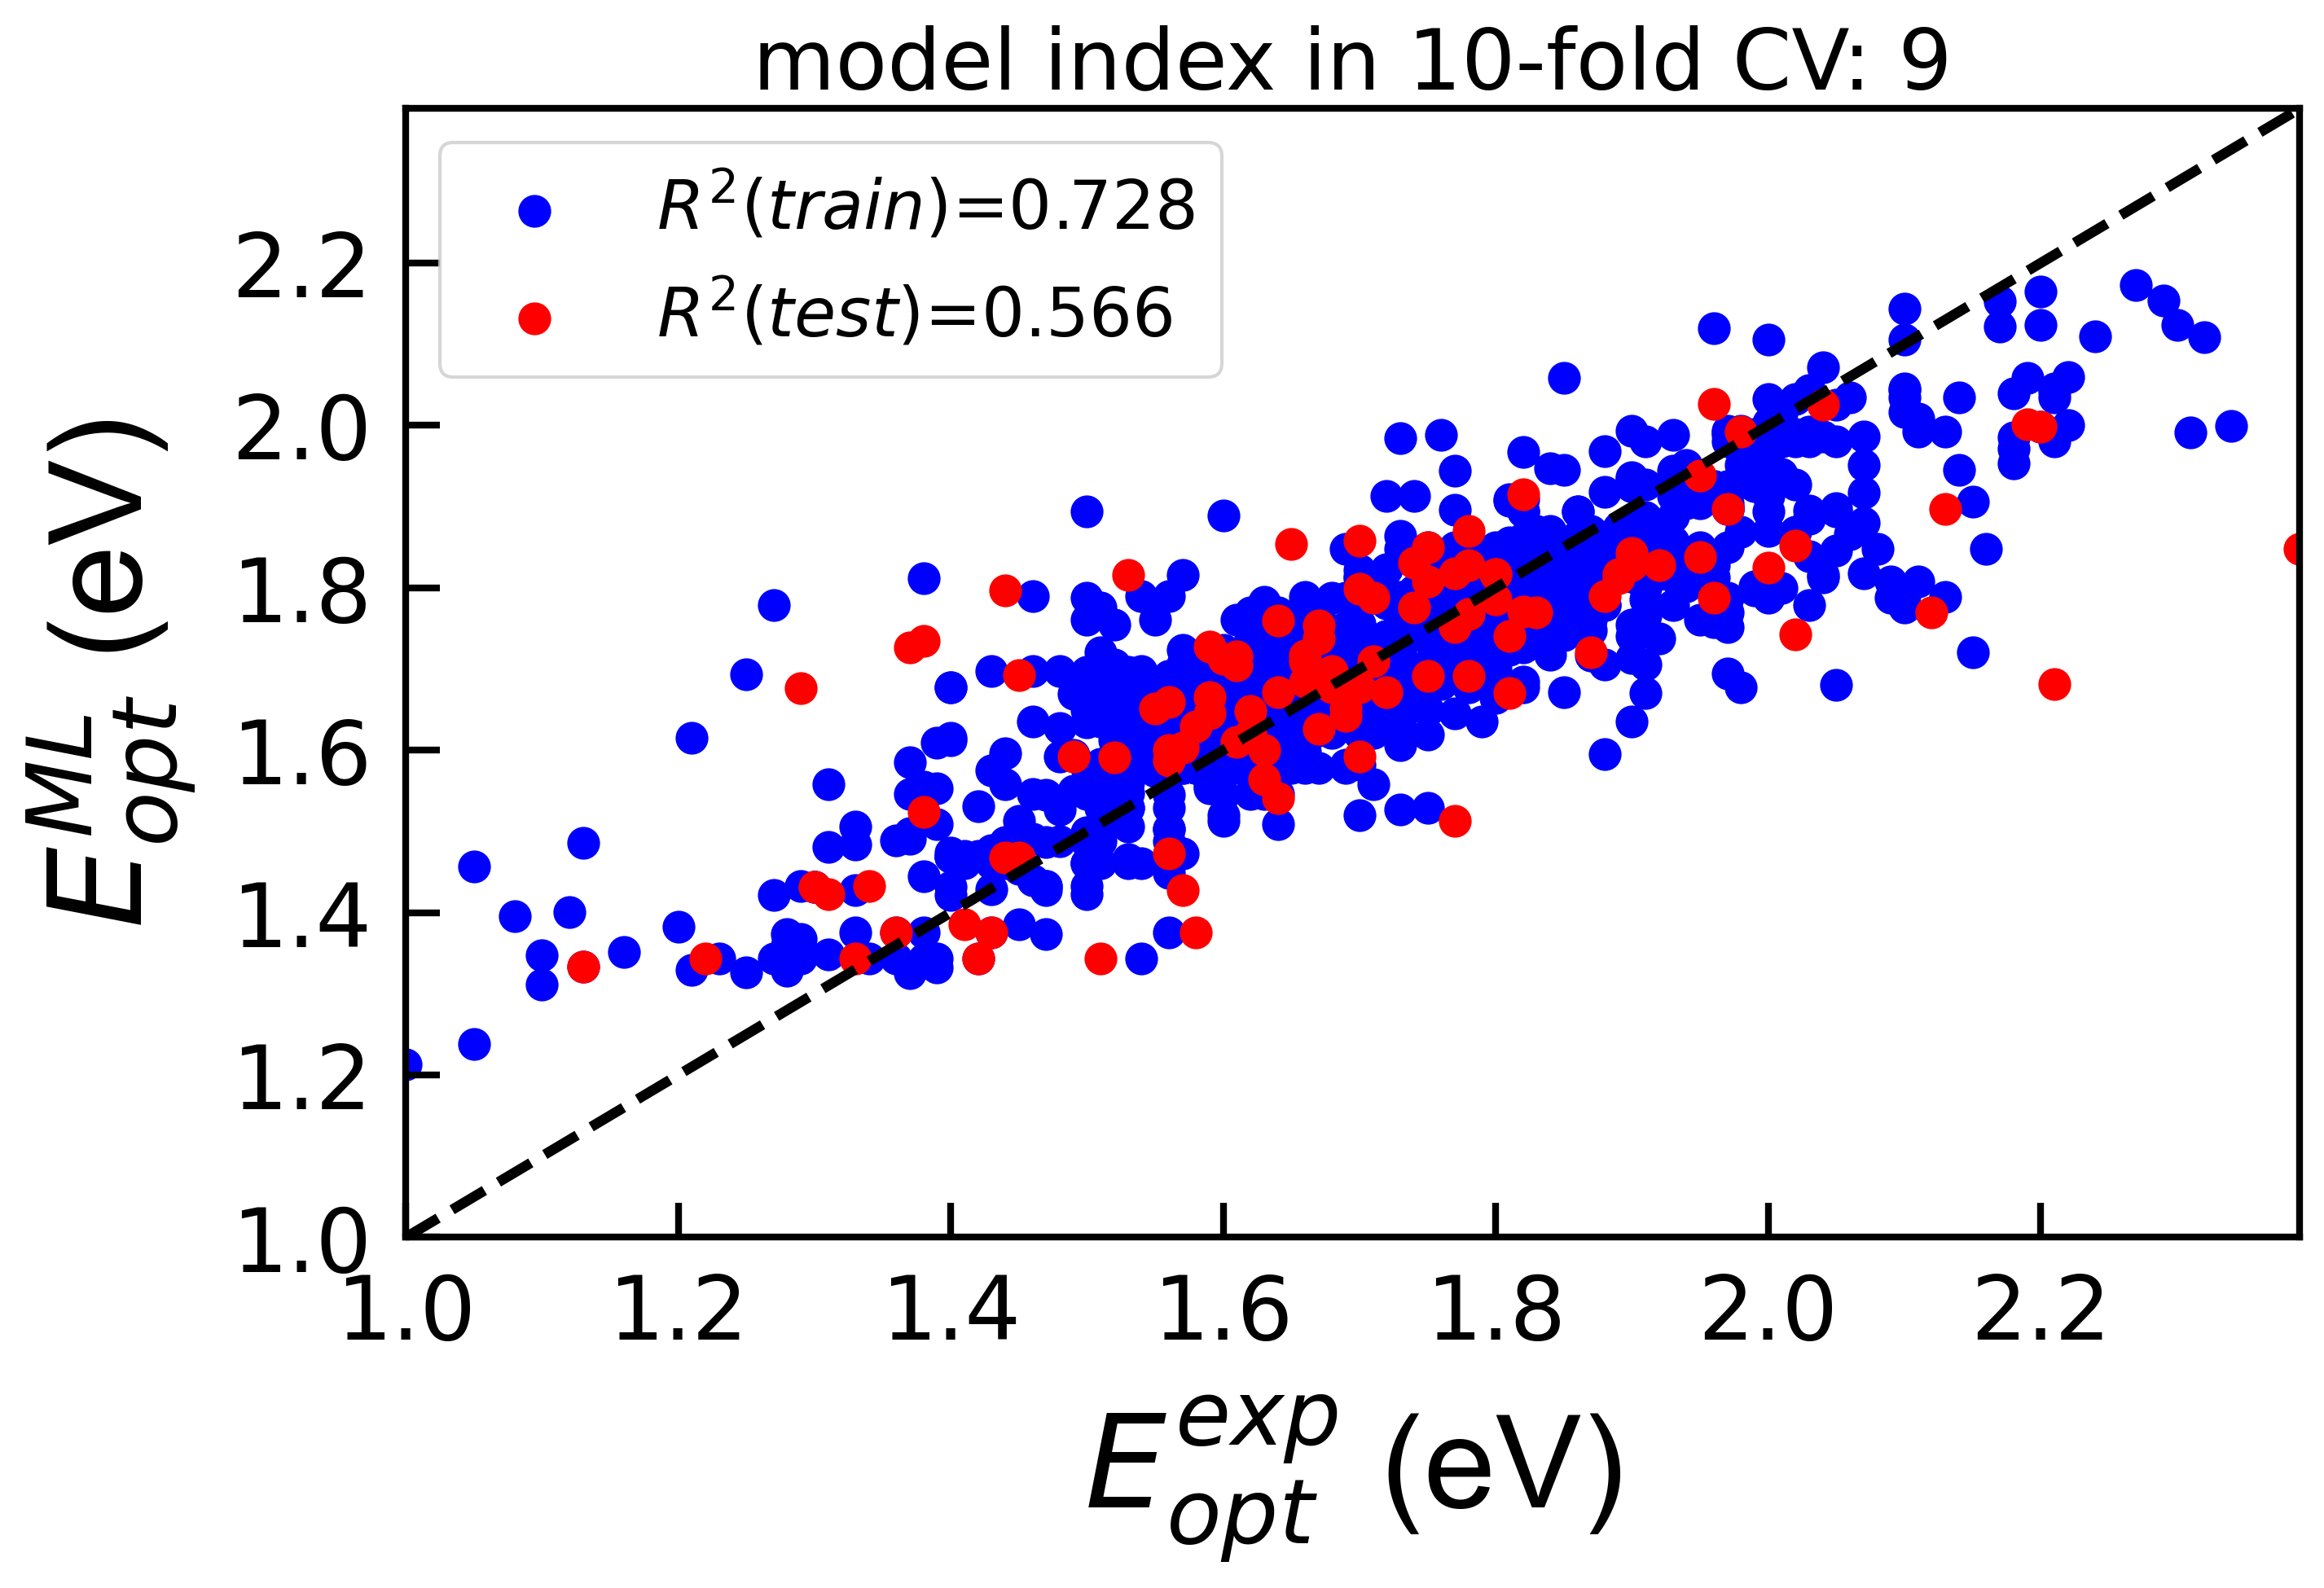

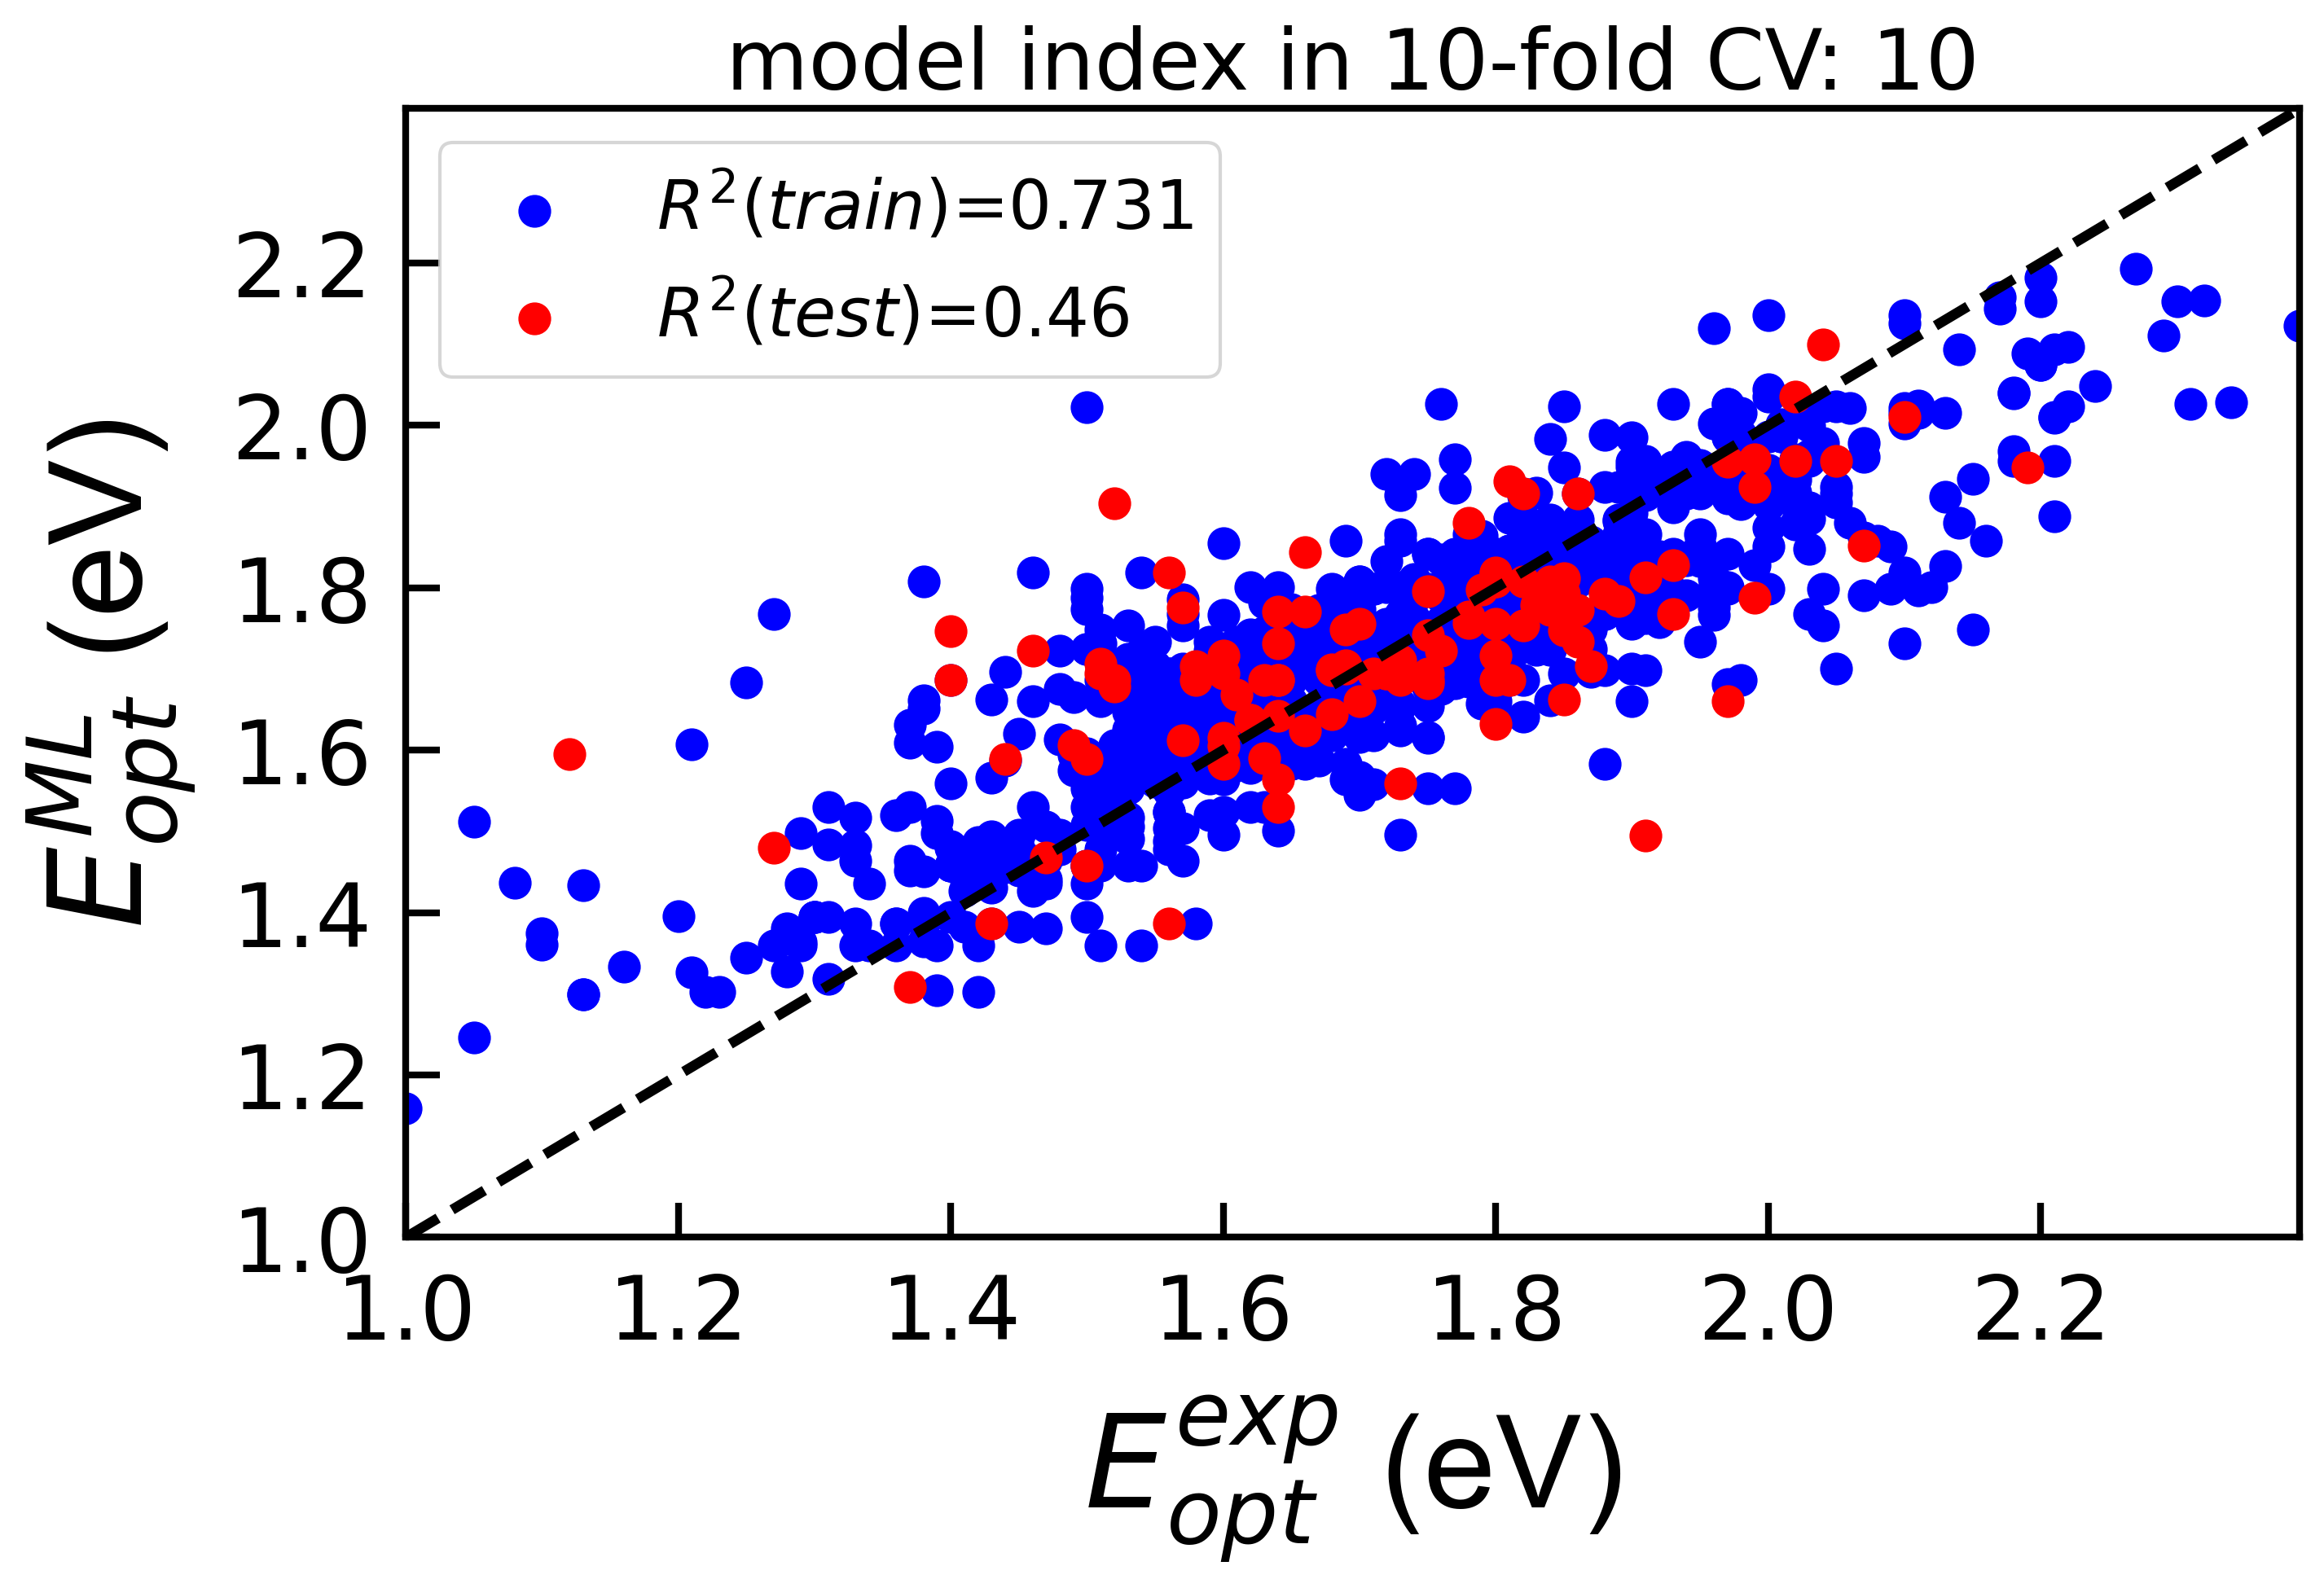

In [24]:
# 5fold-cv models

for i in range(xfold):
    train_index = train_idx_list[i]
    test_index = test_idx_list[i]
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    
    predictions_train = []
    predictions_test = []
    
    # 5fold-cv average for test set
    for j in range(xfold):
        model = models[i*xfold+j]     
               
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
              
        predictions_train.append(y_train_pred)
        predictions_test.append(y_test_pred)
    
    ## average R2 for train in each model
    df_train_pred = pd.DataFrame(predictions_train)
    df_train_pred = df_train_pred.T
    df_train_pred['mean'] = df_train_pred.iloc[:,:4].mean(axis = 1)
    r2_train = r2_score(y_train, df_train_pred['mean'])
    
    ## average R2 for test in each model
    df_test_pred = pd.DataFrame(predictions_test)
    df_test_pred = df_test_pred.T
    df_test_pred['mean'] = df_test_pred.iloc[:,:4].mean(axis = 1)
    r2_test = r2_score(y_test, df_test_pred['mean'])
    
    fold_idx=i+1
    parity_plot(y,y_train, y_test,df_train_pred['mean'], df_test_pred['mean'], r2_train, r2_test, fold_idx)
    